# Compiling data

In [429]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import csv
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
import demoji
from collections import Counter
import nltk
from nltk.corpus import stopwords

In [ ]:
#Importing survey data
df_survey = pd.read_excel('survey_results_data.xlsx')
df_survey.head()

In [15]:
#Drop rows where the response to the survey did not yield a label
df_survey = df_survey.drop(df_survey[df_survey['class_survey'] == "I don't know"].index)
df_survey.shape

(704, 8)

In [16]:
#Check distribution of data for each label
df_survey["class_survey"].value_counts()

class_survey
It is not sarcastic    359
It is sarcastic        345
Name: count, dtype: int64

In [17]:
#Avoid bias from qc questions- drop duplicate text prompts and only keep one of each
df_survey = df_survey.drop_duplicates(subset=['original_text'])

In [18]:
#Check the percentage of results that have emojis

#Convert non-string values to string format
df_survey['edited_text'] = df_survey['edited_text'].astype(str)

#Create a regex pattern to match emojis
emoji_pattern = re.compile("[\U0001F600-\U0001F64F" #Emoticons
                           "\U0001F300-\U0001F5FF"  #Symbols & pictographs
                           "\U0001F680-\U0001F6FF"  #Transport & map symbols
                           "\U0001F1E0-\U0001F1FF"  #Flags
                           "\U00002702-\U000027B0"  #Dingbats
                           "\U000024C2-\U0001F251"  #Enclosed characters
                           "]+", flags=re.UNICODE)

#Use the regex pattern to check if the survey outputs have emojis
df_survey['has_emoji'] = df_survey['edited_text'].apply(lambda x: bool(re.search(emoji_pattern, x)))

#Calculate the percentage of rows that contain emojis
percentage_with_emojis = (df_survey["has_emoji"].sum() / len(df_survey)) * 100

#Print the result
print(f"Percentage of rows with emojis: {percentage_with_emojis:.2f}%")

Percentage of rows with emojis: 63.64%


In [20]:
#Convert labels to 0 and 1 for classification
df_survey['label'] = df_survey['class_survey'].replace({'It is sarcastic': 1, 'It is not sarcastic': 0})
df_survey.head()

,participant_no,over_18,use_emojis,gender,age,original_text,class_survey,edited_text,has_emoji,label
0,1,Yes,Yes,Female,18-24,The only thing I got from college was a caffei...,It is sarcastic,The only thing I got from college was a caffei...,True,1
2,1,Yes,Yes,Female,18-24,"""My (extended) fam was discussing going on a t...",It is sarcastic,"""My (extended) fam was discussing going on a t...",True,1
3,1,Yes,Yes,Female,18-24,i love shoegaze sm,It is sarcastic,i love shoegaze sm 😁,True,1
4,1,Yes,Yes,Female,18-24,men are so grimey,It is sarcastic,men are so grimey 😢,True,1
5,1,Yes,Yes,Female,18-24,okay but like the say so song aint that bad. I...,It is sarcastic,okay but like the say so song aint that bad. I...,True,1


In [21]:
#Rename the edited_text column
df_survey = df_survey.rename(columns={'edited_text': 'tweet'})
df_survey.head()

,participant_no,over_18,use_emojis,gender,age,original_text,class_survey,tweet,has_emoji,label
0,1,Yes,Yes,Female,18-24,The only thing I got from college was a caffei...,It is sarcastic,The only thing I got from college was a caffei...,True,1
2,1,Yes,Yes,Female,18-24,"""My (extended) fam was discussing going on a t...",It is sarcastic,"""My (extended) fam was discussing going on a t...",True,1
3,1,Yes,Yes,Female,18-24,i love shoegaze sm,It is sarcastic,i love shoegaze sm 😁,True,1
4,1,Yes,Yes,Female,18-24,men are so grimey,It is sarcastic,men are so grimey 😢,True,1
5,1,Yes,Yes,Female,18-24,okay but like the say so song aint that bad. I...,It is sarcastic,okay but like the say so song aint that bad. I...,True,1


In [27]:
#Drop all unnecessary columns for the classification task
classification_cols = ['tweet', 'label']
df = df_survey[classification_cols]
df.head()

,tweet,label
0,The only thing I got from college was a caffei...,1
2,"""My (extended) fam was discussing going on a t...",1
3,i love shoegaze sm 😁,1
4,men are so grimey 😢,1
5,okay but like the say so song aint that bad. I...,1


In [28]:
#Importing iSarcasm dataset
df_isarc = pd.read_csv('isarcasm2022.csv')
df_isarc.head()

,Unnamed: 0,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#Drop all unnecessary columns for the classification task
classification_cols = ['tweet', 'sarcastic']
df_isarc = df_isarc[classification_cols]

#Rename the edited_text column
df_isarc = df_isarc.rename(columns={'sarcastic': 'label'})

#Show transformation
df_isarc.head()

,tweet,label
0,The only thing I got from college is a caffein...,1
1,I love it when professors draw a big question ...,1
2,Remember the hundred emails from companies whe...,1
3,Today my pop-pop told me I was not “forced” to...,1
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1


In [30]:
#Check distribution of labels
df_isarc['label'].value_counts()

label
0    2601
1     867
Name: count, dtype: int64

In [31]:
#Drop any tweets from the iSarcasm dataset that were used in the survey as prompts to avoid duplicated entries

#Get a list of unique tweets from the survey 
unique_tweets = df_survey['original_text'].unique()

#Remove rows which would give duplicates of text
df_isarc = df_isarc[~df_isarc['tweet'].isin(unique_tweets)]

#Check distribution of labels
df_isarc.shape

(3291, 2)

In [32]:
#Add the iSarcasm data to the survey data
df = pd.concat([df, df_isarc], ignore_index=True)

#Check the current quantity and distribution of data
df.shape, df['label'].value_counts()

((3995, 2),
 label
 0    2885
 1    1110
 Name: count, dtype: int64)

In [411]:
#Check format
df.head()

,tweet,label
0,The only thing I got from college was a caffei...,1
1,"""My (extended) fam was discussing going on a t...",1
2,i love shoegaze sm 😁,1
3,men are so grimey 😢,1
4,okay but like the say so song aint that bad. I...,1


In [412]:
#Save as csv
df.to_csv('validated_tweets.csv', index=False)

# Checking data augmentation methods

In [46]:
#Importing libraries 
import random
import nlpaug.augmenter.word as naw
from transformers import pipeline

In [37]:
#Define function to perform augmentation
def augment_text(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    return augmented_text

In [39]:
#Randomly select 25 rows from the df to check the effects of augmentation
random.seed(42)
selected_rows = random.sample(range(len(df)), 25)

#Create a variable to store results
augmented_data = {'original_text': [], 'augmented_text': []}

#Augment text sample
for row in selected_rows:
    original_text = df.loc[row, 'tweet']
    augmented_text = augment_text(original_text)
    
    augmented_data['original_text'].append(original_text)
    augmented_data['augmented_text'].append(augmented_text)

#Convert to df
augmented_df = pd.DataFrame(augmented_data)

#Check results
augmented_df.head()

,original_text,augmented_text
0,"“Oven ready, shove it in the microwave” and th...","[“ Oven ready, thrust it in the microwave oven..."
1,@DarkenerWoW @wochinimen @MissPurplePixie shit...,[@ DarkenerWoW @ wochinimen @ MissPurplePixie ...
2,i have this reoccurring nightmare where i acci...,[i make this reoccurring incubus where i by ch...
3,"Happy Trans Visibility Day all my beautiful, s...","[Happy Trans Visibility Day all my beautiful, ..."
4,"""Should I wear my lime green pants?"" dad its 4...","["" Should Iodin wear my lime light green pants..."


In [44]:
#Check if it kept the emojis

#Convert non-string values to string format
augmented_df['augmented_text'] = augmented_df['augmented_text'].astype(str)
augmented_df['original_text'] = augmented_df['original_text'].astype(str)

#Use the regex pattern to check if the survey outputs have emojis
augmented_df['has_emoji'] = augmented_df['augmented_text'].apply(lambda x: bool(re.search(emoji_pattern, x)))
augmented_df['has_emoji_orig'] = augmented_df['original_text'].apply(lambda x: bool(re.search(emoji_pattern, x)))

#Check distribution with emojis
augmented_df['has_emoji'].value_counts(), augmented_df['has_emoji_orig'].value_counts()

(has_emoji
 False    14
 True     11
 Name: count, dtype: int64,
 has_emoji_orig
 False    14
 True     11
 Name: count, dtype: int64)

In [45]:
#Manually evaluate results
print('Before:')
print(augmented_df['original_text'].iloc[0])
print('After:')
print(augmented_df['augmented_text'].iloc[0])
print()
print('Before:')
print(augmented_df['original_text'].iloc[1])
print('After:')
print(augmented_df['augmented_text'].iloc[1])
print()
print('Before:')
print(augmented_df['original_text'].iloc[2])
print('After:')
print(augmented_df['augmented_text'].iloc[2])
print()
print('Before:')
print(augmented_df['original_text'].iloc[3])
print('After:')
print(augmented_df['augmented_text'].iloc[3])
print()
print('Before:')
print(augmented_df['original_text'].iloc[4])
print('After:')
print(augmented_df['augmented_text'].iloc[4])
print()
print('Before:')
print(augmented_df['original_text'].iloc[5])
print('After:')
print(augmented_df['augmented_text'].iloc[5])
print()
print('Before:')
print(augmented_df['original_text'].iloc[6])
print('After:')
print(augmented_df['augmented_text'].iloc[6])
print()
print('Before:')
print(augmented_df['original_text'].iloc[7])
print('After:')
print(augmented_df['augmented_text'].iloc[7])
print()
print('Before:')
print(augmented_df['original_text'].iloc[8])
print('After:')
print(augmented_df['augmented_text'].iloc[8])
print()
print('Before:')
print(augmented_df['original_text'].iloc[9])
print('After:')
print(augmented_df['augmented_text'].iloc[9])
print()

Before:
“Oven ready, shove it in the microwave” and this man is our PM✌🏼
After:
['“ Oven ready, thrust it in the microwave oven ” and this man follow our PM ✌ 🏼']

Before:
@DarkenerWoW @wochinimen @MissPurplePixie shit healer
After:
['@ DarkenerWoW @ wochinimen @ MissPurplePixie shit healer']

Before:
i have this reoccurring nightmare where i accidentally forget to put on shoes before school and i have to spend the whole day barefoot
After:
['i make this reoccurring incubus where i by chance forget to put on shoes before school day and i have to spend the whole daytime barefoot']

Before:
Happy Trans Visibility Day all my beautiful, strong, and sexy trans peeps!! We are unapologetically ourselves 💜
After:
['Happy Trans Visibility Day all my beautiful, unattackable, and aphrodisiac trans peeps! ! We are unapologetically ourselves 💜']

Before:
"Should I wear my lime green pants?" dad its 4th of july...
After:
['" Should Iodin wear my lime light green pants? " dad its fourth of july. ..']

In [50]:
#Try use of paraphrasing to augment text

#Randomly select 25 rows from the df to check the effects of augmentation
random.seed(51)
selected_rows = random.sample(range(len(df)), 25)

#Initialise text generation pipeline with pre-trained model
generator = pipeline("text-generation", model="EleutherAI/gpt-neo-1.3B")

#Function to perform text paraphrasing
def paraphrase_text(text, num_paraphrase=5):
    paraphrased_texts = []
    for _ in range(num_paraphrase):
        paraphrased_text = generator(text, max_length=200, num_return_sequences=1, do_sample=True)[0]["generated_text"]
        paraphrased_texts.append(paraphrased_text)
    return paraphrased_texts

#Create a variable to store results
paraphrased_data = {'original_text': [], 'paraphrased_text': []}

#Augment text sample
for row in selected_rows:
    original_text = df.loc[row, 'tweet']
    paraphrased_text = paraphrase_text(original_text)
    
    paraphrased_data['original_text'].append(original_text)
    paraphrased_data['paraphrased_text'].append(paraphrased_text)

#Convert to df
paraphrased_df = pd.DataFrame(paraphrased_data)

#Check results
paraphrased_df.head()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 64, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 64, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 64, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 64, but `max_length` is set to 50. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 64, but

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

,original_text,paraphrased_text
0,"My dad just said to me, “Hey, you’re kinda ski...","[My dad just said to me, “Hey, you’re kinda sk..."
1,Post university anxiety is creeping in now lik...,[Post university anxiety is creeping in now li...
2,My department is hiring in metaphysics and epi...,[My department is hiring in metaphysics and ep...
3,Seeing my friends shine is so heartwarming 🥺🥺,[Seeing my friends shine is so heartwarming 🥺🥺...
4,If your website still has a google plus share ...,[If your website still has a google plus share...


In [51]:
#Check if it kept the emojis

#Convert non-string values to string format
paraphrased_df['paraphrased_text'] = paraphrased_df['paraphrased_text'].astype(str)
paraphrased_df['original_text'] = paraphrased_df['original_text'].astype(str)

#Use the regex pattern to check if the survey outputs have emojis
paraphrased_df['has_emoji'] = paraphrased_df['paraphrased_text'].apply(lambda x: bool(re.search(emoji_pattern, x)))
paraphrased_df['has_emoji_orig'] = paraphrased_df['original_text'].apply(lambda x: bool(re.search(emoji_pattern, x)))

#Check distribution with emojis
paraphrased_df['has_emoji'].value_counts(), paraphrased_df['has_emoji_orig'].value_counts()

(has_emoji
 False    20
 True      5
 Name: count, dtype: int64,
 has_emoji_orig
 False    23
 True      2
 Name: count, dtype: int64)

In [52]:
#Manually evaluate results
print('Before:')
print(paraphrased_df['original_text'].iloc[0])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[0])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[1])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[1])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[2])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[2])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[3])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[3])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[4])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[4])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[5])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[5])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[6])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[6])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[7])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[7])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[8])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[8])
print()
print('Before:')
print(paraphrased_df['original_text'].iloc[9])
print('After:')
print(paraphrased_df['paraphrased_text'].iloc[9])

Before:
My dad just said to me, “Hey, you’re kinda skinny, can you slip behind the fridge to look at something?” and it might be the nicest compliment I’ve ever gotten. So guys, go tell your girl you think she’s kinda skinny🥰
After:
['My dad just said to me, “Hey, you’re kinda skinny, can you slip behind the fridge to look at something?” and it might be the nicest compliment I’ve ever gotten. So guys, go tell your girl you think she’s kinda skinny🥰 (', 'My dad just said to me, “Hey, you’re kinda skinny, can you slip behind the fridge to look at something?” and it might be the nicest compliment I’ve ever gotten. So guys, go tell your girl you think she’s kinda skinny🥰\n', 'My dad just said to me, “Hey, you’re kinda skinny, can you slip behind the fridge to look at something?” and it might be the nicest compliment I’ve ever gotten. So guys, go tell your girl you think she’s kinda skinny🥰�', 'My dad just said to me, “Hey, you’re kinda skinny, can you slip behind the fridge to look at some

# Collect datasets for compilation with current data

In [68]:
#Importing SarcEval dataset
df_eval = pd.read_csv('english_task_a.csv')
df_eval.head()

,text,sarcasm_ref,human_aggregated,#humans_sarcasm
0,"Size on the the Toulouse team, That pack is mo...",0,0,1
1,Pinball!,0,0,0
2,So the Scottish Government want people to get ...,1,1,4
3,villainous pro tip : change the device name on...,0,0,0
4,I would date any of these men 🥺,0,0,1


In [69]:
#Format for the evaluation

#Rename the label column
df_eval = df_eval.rename(columns={'sarcasm_ref': 'label'})

#Drop all unnecessary columns
classification_cols = ['text', 'label']
df_eval = df_eval[classification_cols]

#Check df format and size
df_eval.head(), df_eval.shape

(                                                text  label
 0  Size on the the Toulouse team, That pack is mo...      0
 1                                           Pinball!      0
 2  So the Scottish Government want people to get ...      1
 3  villainous pro tip : change the device name on...      0
 4                    I would date any of these men 🥺      0,
 (1400, 2))

In [70]:
#Importing #sarcasm and #irony dataset
df_add = pd.read_csv('train.csv')
df_add.head()

,tweets,class
0,Be aware dirty step to get money #staylight ...,figurative
1,#sarcasm for #people who don't understand #diy...,figurative
2,@IminworkJeremy @medsingle #DailyMail readers ...,figurative
3,@wilw Why do I get the feeling you like games?...,figurative
4,-@TeacherArthurG @rweingarten You probably jus...,figurative


In [71]:
#Format for the evaluation

#Rename the label column
df_add = df_add.rename(columns={'tweets': 'text'})

#All tweets are sarcastic- relabel them all as 1
df_add['label'] = 1

#Drop all unnecessary columns
classification_cols = ['text', 'label']
df_add = df_add[classification_cols]

#Check df format and size
df_add.head(), df_add.shape

(                                                text  label
 0  Be aware  dirty step to get money  #staylight ...      1
 1  #sarcasm for #people who don't understand #diy...      1
 2  @IminworkJeremy @medsingle #DailyMail readers ...      1
 3  @wilw Why do I get the feeling you like games?...      1
 4  -@TeacherArthurG @rweingarten You probably jus...      1,
 (81408, 2))

In [72]:
#Remove specific hashtags from the text
df_add['text'] = df_add['text'].str.replace(r'#sarcasm\b', '', regex=True)
df_add['text'] = df_add['text'].str.replace(r'#irony\b', '', regex=True)
df_add['text'] = df_add['text'].str.replace(r'#sarcastic\b', '', regex=True)

#Check transformation
df_add.head()

,text,label
0,Be aware dirty step to get money #staylight ...,1
1,for #people who don't understand #diy #artatt...,1
2,@IminworkJeremy @medsingle #DailyMail readers ...,1
3,@wilw Why do I get the feeling you like games?,1
4,-@TeacherArthurG @rweingarten You probably jus...,1


In [73]:
#Repeat using the test data

#Importing #sarcasm and #irony dataset
df_add1 = pd.read_csv('test.csv')
df_add1.head()

,tweets,class
0,no one ever predicted this was going to happen...,figurative
1,@Stooshie its as closely related as Andrews or...,figurative
2,I find it ironic when Vegans say they love foo...,figurative
3,Quick rt that throwing money vine I've not see...,figurative
4,"yep, keep adding me to your #devops lists.... ...",figurative


In [74]:
#Format for the evaluation

#Rename the label column
df_add1 = df_add1.rename(columns={'tweets': 'text'})

#All tweets are sarcastic- relabel them all as 1
df_add1['label'] = 1

#Drop all unnecessary columns
classification_cols = ['text', 'label']
df_add1 = df_add1[classification_cols]

#Remove specific hashtags from the text
df_add1['text'] = df_add1['text'].str.replace(r'#sarcasm\b', '', regex=True)
df_add1['text'] = df_add1['text'].str.replace(r'#irony\b', '', regex=True)
df_add1['text'] = df_add1['text'].str.replace(r'#sarcastic\b', '', regex=True)

#Check df format and size
df_add1.head(), df_add1.shape

(                                                text  label
 0  no one ever predicted this was going to happen...      1
 1  @Stooshie its as closely related as Andrews or...      1
 2  I find it ironic when Vegans say they love foo...      1
 3  Quick rt that throwing money vine I've not see...      1
 4  yep, keep adding me to your #devops lists.... ...      1,
 (8128, 2))

In [75]:
#Combine the dfs using the same collection strategy
df_add = pd.concat([df_add, df_add1], ignore_index=True)

#Check df size and form
df_add.head(), df_add.shape

(                                                text  label
 0  Be aware  dirty step to get money  #staylight ...      1
 1   for #people who don't understand #diy #artatt...      1
 2  @IminworkJeremy @medsingle #DailyMail readers ...      1
 3    @wilw Why do I get the feeling you like games?       1
 4  -@TeacherArthurG @rweingarten You probably jus...      1,
 (89536, 2))

In [81]:
#Check distribution of labels
df_add['label'].value_counts()

label
1    89536
Name: count, dtype: int64

In [76]:
#Specify the file path to read in next dataset- dataset collected and annotated using weak labels -> #not and offensive vocab
file_path = 'Train_v1.txt' 

#Read the data into a df
df_add1 = pd.read_csv(file_path, delimiter='\t', header=None, names=['Column1', 'Column2', 'Column3'])

#Check the df
df_add1.head()

,Column1,Column2,Column3
0,TrainSen,0,@0430yes i hope youre lurking rn. i want to li...
1,TrainSen,0,05 really taught me a valuable lesson I'm neve...
2,TrainSen,0,"@098BERRY Never had a voice to protest, so you..."
3,TrainSen,0,@0hMySt4rs Rest in peace & love to you and you...
4,TrainSen,0,100 days until Christmas! 🌲 #too soon #not rea...


In [77]:
#Rename cols based on the contents
df_add1 = df_add1.rename(columns={'Column2': 'label'})
df_add1 = df_add1.rename(columns={'Column3': 'text'})

#Drop unnecessary columns
classification_cols = ['text', 'label']
df_add1 = df_add1[classification_cols]

#Check df form and size
df_add1.head(), df_add1.shape

(                                                text  label
 0  @0430yes i hope youre lurking rn. i want to li...      0
 1  05 really taught me a valuable lesson I'm neve...      0
 2  @098BERRY Never had a voice to protest, so you...      0
 3  @0hMySt4rs Rest in peace & love to you and you...      0
 4  100 days until Christmas! 🌲 #too soon #not rea...      0,
 (39780, 2))

In [79]:
#Dataset collected and annotated using weak labels -> #not and offensive vocab

#Specify the file path to read in next dataset 
file_path = 'Test_v1.txt' 

#Read the data into a df
df_add2 = pd.read_csv(file_path, delimiter='\t', header=None, names=['Column1', 'label', 'text'])

#Drop unnecessary columns
classification_cols = ['text', 'label']
df_add2 = df_add2[classification_cols]

#Check the df
df_add2.head(), df_add2.shape

(                                                text  label
 0  I loovee when people text back ... 😒 #sarcasti...      1
 1  Don't you love it when your parents are Pissed...      1
 2      So many useless classes , great to be student      1
 3  Oh how I love getting home from work at 3am an...      1
 4          I just love having grungy ass hair 😑 #not      1,
 (1975, 2))

In [80]:
#Combine the dfs using the same collection strategy
df_add1 = pd.concat([df_add1, df_add2], ignore_index=True)

#Check df size and form
df_add1.head(), df_add1.shape

(                                                text  label
 0  @0430yes i hope youre lurking rn. i want to li...      0
 1  05 really taught me a valuable lesson I'm neve...      0
 2  @098BERRY Never had a voice to protest, so you...      0
 3  @0hMySt4rs Rest in peace & love to you and you...      0
 4  100 days until Christmas! 🌲 #too soon #not rea...      0,
 (41755, 2))

In [82]:
#Check distribution of labels
df_add1['label'].value_counts()

label
0    22267
1    19488
Name: count, dtype: int64

In [84]:
#Dataset by Riloff

#Specify the file path to read in next dataset
file_path = 'train.txt' 

#Read the data into a df
df_add2 = pd.read_csv(file_path, delimiter='\t', header=None, names=['text'])

#All tweets are sarcastic- relabel them all as 1
df_add2['label'] = 1

#Check the df
df_add2.head(), df_add2.shape

(                                                text  label
 0  Nih min buat fans arsenal @my_supersoccer :D h...      1
 1  Give a person power that will be a true test o...      1
 2  @LordWilsonVILLA At 21 he looks to have a lot ...      1
 3  I'm about to fall asleep and I still have to b...      1
 4  I love hearing the shots from the shooting ran...      1,
 (1368, 2))

In [85]:
#Repeat for the train data

#Specify the file path to read in next dataset
file_path = 'test.txt' 

#Read the data into a df
df_add3 = pd.read_csv(file_path, delimiter='\t', header=None, names=['text'])

#All tweets are sarcastic- relabel them all as 1
df_add3['label'] = 1

#Check the df
df_add3.head(), df_add3.shape

(                                                text  label
 0  Absolutely love when water is spilt on my phon...      1
 1  I was hoping just a LITTLE more shit could hit...      1
 2  @pdomo Don't forget that Nick Foles is also th...      1
 3  I constantly see tweets about Arsenal on twitt...      1
 4  Can feel the feet pulsating...slow one...becau...      1,
 (588, 2))

In [86]:
#Combine the dfs using the same collection strategy
df_add2 = pd.concat([df_add2, df_add3], ignore_index=True)

#Check df size and form
df_add2.head(), df_add2.shape

(                                                text  label
 0  Nih min buat fans arsenal @my_supersoccer :D h...      1
 1  Give a person power that will be a true test o...      1
 2  @LordWilsonVILLA At 21 he looks to have a lot ...      1
 3  I'm about to fall asleep and I still have to b...      1
 4  I love hearing the shots from the shooting ran...      1,
 (1956, 2))

In [87]:
#Check distribution of labels
df_add2['label'].value_counts()

label
1    1956
Name: count, dtype: int64

In [88]:
#Dataset by Ghosh- uses weak labelling with #sarcasm

#Specify the file path to read in next dataset
file_path = 'train (1).txt' 

#Read the data into a df
df_add3 = pd.read_csv(file_path, delimiter='\t', header=None, names=['Column1', 'Column2', 'Column3'])

#Check the df
df_add3.head()

,Column1,Column2,Column3
0,TrainSen,1,It feels like just a few days ago it was the l...
1,TrainSen,1,"I love my mom . No matter what we go through ,..."
2,TrainSen,1,Bump that music ... #imtryingtosleep #sarcasm
3,TrainSen,0,Mexican and black jokes are pretty much the sa...
4,TrainSen,0,How to find work you love :


In [90]:
#Rename cols based on the contents
df_add3 = df_add3.rename(columns={'Column2': 'label'})
df_add3 = df_add3.rename(columns={'Column3': 'text'})

#Drop unnecessary columns
classification_cols = ['text', 'label']
df_add3 = df_add3[classification_cols]

#Remove weak label
df_add3['text'] = df_add3['text'].str.replace(r'#sarcasm\b', '', regex=True)

#Check df form and size
df_add3.head(), df_add3.shape

(                                                text  label
 0  It feels like just a few days ago it was the l...      1
 1  I love my mom . No matter what we go through ,...      1
 2              Bump that music ... #imtryingtosleep       1
 3  Mexican and black jokes are pretty much the sa...      0
 4                        How to find work you love :      0,
 (51189, 2))

In [91]:
#Repeat for test data

#Specify the file path to read in next dataset
file_path = 'test (1).txt' 

#Read the data into a df
df_add4 = pd.read_csv(file_path, delimiter='\t', header=None, names=['Column1', 'label', 'text'])

#Drop unnecessary columns
classification_cols = ['text', 'label']
df_add4 = df_add4[classification_cols]

#Remove weak label
df_add4['text'] = df_add4['text'].str.replace(r'#sarcasm\b', '', regex=True)

#Combine the dfs using the same collection strategy
df_add3 = pd.concat([df_add3, df_add4], ignore_index=True)

#Check df form and size
df_add3.head(), df_add3.shape

(                                                text  label
 0  It feels like just a few days ago it was the l...      1
 1  I love my mom . No matter what we go through ,...      1
 2              Bump that music ... #imtryingtosleep       1
 3  Mexican and black jokes are pretty much the sa...      0
 4                        How to find work you love :      0,
 (54877, 2))

In [102]:
#Compile data with weak labels consisting of offensive vocab and key hashtags

#Open the csv file to adjust format and define a new one for the corrected formatting
with open('dataset_csv.csv', 'r', encoding='utf-8') as input_file, \
     open('output.csv', 'w', encoding='utf-8', newline='') as output_file:

    csv_reader = csv.reader(input_file)
    csv_writer = csv.writer(output_file)

    #Where row has tweet split into several cells, concatenate into a single cell
    for row in csv_reader:
        if len(row) > 1:  
            full_tweet = ' '.join(row[1:])
            csv_writer.writerow([row[0], full_tweet])
        else:
            csv_writer.writerow(row)

print("CSV file preprocessing complete.")

CSV file preprocessing complete.


In [104]:
#Import corrected data and check the format
df_add4 = pd.read_csv('output.csv', delimiter='\t')
df_add4.head()

,tweets,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [105]:
#Adjust column naming for continuity 
df_add4 = df_add4.rename(columns={'tweets': 'text'})

#Check data format and size
df_add4.head(), df_add4.shape

(                                                text label
 0                    I love working midnights tweet      1
 1  I hate when I buy a bag of air and there's chi...     1
 2  my grandad always sounds so ill when i speak t...     0
 3  I realize I'm annoying to everyone, so I won't...     0
 4  I love when I find these dudes on vine!! #Foll...     1,
 (1994, 2))

# Filter for sarcastic tweets with similar important features to the sarcastic features identified before

In [106]:
#Check shape of the data
df_add.shape, df_add1.shape, df_add2.shape, df_add3.shape, df_add4.shape

((89536, 2), (41755, 2), (1956, 2), (54877, 2), (1994, 2))

# Prepare baseline data for comparison

In [143]:
#Check structure of the data
df.head()

,tweet,label
0,The only thing I got from college was a caffei...,1
1,"""My (extended) fam was discussing going on a t...",1
2,i love shoegaze sm 😁,1
3,men are so grimey 😢,1
4,okay but like the say so song aint that bad. I...,1


In [144]:
#Check distribution of labels
print(df['label'].value_counts())

label
0    2885
1    1110
Name: count, dtype: int64


In [145]:
#Check for null values 
print(df.isnull().sum())

#Drop rows with null values
df.dropna(axis=0, inplace=True)

tweet    1
label    0
dtype: int64


In [146]:
#Pull out sarcastic tweets only
df_sarc = df[df['label'] == 1]

In [153]:
#Get sentiment data for each row
df_sarc['sentiment_result'] = df_sarc['tweet'].apply(calculate_probabilities)

#Use the data to determine positive/negative rows
df_sarc['sentiment_label'] = df_sarc['sentiment_result'].apply(determine_sentiment)

C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3074321459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sarc['sentiment_result'] = df_sarc['tweet'].apply(calculate_probabilities)
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3074321459.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sarc['sentiment_label'] = df_sarc['sentiment_result'].apply(determine_sentiment)


In [154]:
#Create positive and negative subsets 
df_pos = df_sarc[(df_sarc['sentiment_label'] == 'positive')]
df_neg = df_sarc[(df_sarc['sentiment_label'] == 'negative')]

In [155]:
#Check df
df_pos.head()

,tweet,label,sentiment_result,sentiment_label
0,The only thing I got from college was a caffei...,1,"[0.1715908795595169, 0.5636150240898132, 0.264...",positive
1,"""My (extended) fam was discussing going on a t...",1,"[0.21971991658210754, 0.37854474782943726, 0.4...",positive
2,i love shoegaze sm 😁,1,"[0.0015152746345847845, 0.00982738845050335, 0...",positive
4,okay but like the say so song aint that bad. I...,1,"[0.02680261805653572, 0.2406616508960724, 0.73...",positive
5,Tinnitus is my favourite thing ever I love it....,1,"[0.0021385003346949816, 0.0065424032509326935,...",positive


# Break down each new dataset by polarity

In [109]:
#Sarcastic tweets only
print(df_add['label'].value_counts())
print(df_add1['label'].value_counts())
print(df_add2['label'].value_counts())
print(df_add3['label'].value_counts())
print(df_add4['label'].value_counts())

label
1    89536
Name: count, dtype: int64
label
0    22267
1    19488
Name: count, dtype: int64
label
1    1956
Name: count, dtype: int64
label
0    29016
1    25861
Name: count, dtype: int64
label
0     987
1     958
0"      9
1"      2
Name: count, dtype: int64


In [110]:
#Remove unusually formatted labels from the last df
df_add4 = df_add4[df_add4['label'] != '0"']
df_add4 = df_add4[df_add4['label'] != '1"']

#Check data 
print(df_add4['label'].value_counts())

label
0    987
1    958
Name: count, dtype: int64


In [119]:
#Check datatypes for each set
print(df_add.dtypes)
print(df_add1.dtypes)
print(df_add2.dtypes)
print(df_add3.dtypes)
print(df_add4.dtypes)

text     object
label     int64
dtype: object
text     object
label     int64
dtype: object
text     object
label     int64
dtype: object
text     object
label     int64
dtype: object
text     object
label    object
dtype: object


In [125]:
#Check for null values 
print(df_add.isnull().sum())
print(df_add1.isnull().sum())
print(df_add2.isnull().sum())
print(df_add3.isnull().sum())
print(df_add4.isnull().sum())

text     2
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text      0
label    38
dtype: int64


In [126]:
#Drop rows with null values
df_add.dropna(axis=0, inplace=True)
df_add4.dropna(axis=0, inplace=True)

#Confirm no null values
print(df_add.isnull().sum())
print(df_add1.isnull().sum())
print(df_add2.isnull().sum())
print(df_add3.isnull().sum())
print(df_add4.isnull().sum())

text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


In [127]:
#Convert object to integer
df_add4['label'] = df_add4['label'].astype('int64')

#Check
print(df_add4.dtypes)

text     object
label     int64
dtype: object


In [132]:
#Pull out sarcastic tweets only where needed
df_add1_sarc = df_add1[df_add1['label'] == 1]
df_add3_sarc = df_add3[df_add3['label'] == 1]
df_add4_sarc = df_add4[df_add4['label'] == 1]


#Confirm nothing is missed
print(df_add['label'].value_counts())
print(df_add1_sarc['label'].value_counts())
print(df_add2['label'].value_counts())
print(df_add3_sarc['label'].value_counts())
print(df_add4_sarc['label'].value_counts())

label
1    89534
Name: count, dtype: int64
label
1    19488
Name: count, dtype: int64
label
1    1956
Name: count, dtype: int64
label
1    25861
Name: count, dtype: int64
label
1    958
Name: count, dtype: int64


In [405]:
#Make a subset of all non-sarcastic text
df_add1_nonsarc = df_add1[df_add1['label'] == 0]
df_add3_nonsarc = df_add3[df_add3['label'] == 0]
df_add4_nonsarc = df_add4[df_add4['label'] == 0]

#Combine them into one master df
add_overall_nonsarc = pd.concat([df_add1_nonsarc, df_add3_nonsarc, df_add4_nonsarc], ignore_index=True)

#Check the shape
add_overall_nonsarc.shape

(52270, 2)

In [406]:
#Check the format
add_overall_nonsarc.head()

,text,label
0,@0430yes i hope youre lurking rn. i want to li...,0
1,05 really taught me a valuable lesson I'm neve...,0
2,"@098BERRY Never had a voice to protest, so you...",0
3,@0hMySt4rs Rest in peace & love to you and you...,0
4,100 days until Christmas! 🌲 #too soon #not rea...,0


In [135]:
#Break down into positive and negative subsets to get the best outcomes

#Use the same sentiment polarity model as before
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

#Create the sentiment analysis pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
#Function to calculate probabilities
def calculate_probabilities(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
    return probabilities

In [139]:
#Apply function to each df
df_add['sentiment_result'] = df_add['text'].apply(calculate_probabilities)
df_add1_sarc['sentiment_result'] = df_add1_sarc['text'].apply(calculate_probabilities)
df_add2['sentiment_result'] = df_add2['text'].apply(calculate_probabilities)
df_add3_sarc['sentiment_result'] = df_add3_sarc['text'].apply(calculate_probabilities)
df_add4_sarc['sentiment_result'] = df_add4_sarc['text'].apply(calculate_probabilities)

C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3467284177.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_add1_sarc['sentiment_result'] = df_add1_sarc['text'].apply(calculate_probabilities)
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3467284177.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_add3_sarc['sentiment_result'] = df_add3_sarc['text'].apply(calculate_probabilities)
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3467284177.py:6: SettingWithCopyWarning: 
A value is trying to

In [140]:
#Function to determine sentiment label based on probabilities
def determine_sentiment(probabilities):
    if probabilities[2] > probabilities[0]:
        return 'positive'
    else:
        return 'negative'

In [141]:
#Apply function to each df
df_add['sentiment_label'] = df_add['sentiment_result'].apply(determine_sentiment)
df_add1_sarc['sentiment_label'] = df_add1_sarc['sentiment_result'].apply(determine_sentiment)
df_add2['sentiment_label'] = df_add2['sentiment_result'].apply(determine_sentiment)
df_add3_sarc['sentiment_label'] = df_add3_sarc['sentiment_result'].apply(determine_sentiment)
df_add4_sarc['sentiment_label'] = df_add4_sarc['sentiment_result'].apply(determine_sentiment)

C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\473457995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_add1_sarc['sentiment_label'] = df_add1_sarc['sentiment_result'].apply(determine_sentiment)
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\473457995.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_add3_sarc['sentiment_label'] = df_add3_sarc['sentiment_result'].apply(determine_sentiment)
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\473457995.py:6: SettingWithCopyWarning: 
A value i

In [142]:
#Generate positive and negative subsets for each df
add_pos = df_add[(df_add['sentiment_label'] == 'positive')]
add_neg = df_add[(df_add['sentiment_label'] == 'negative')]

add1_pos = df_add1_sarc[(df_add1_sarc['sentiment_label'] == 'positive')]
add1_neg = df_add1_sarc[(df_add1_sarc['sentiment_label'] == 'negative')]

add2_pos = df_add2[(df_add2['sentiment_label'] == 'positive')]
add2_neg = df_add2[(df_add2['sentiment_label'] == 'negative')]

add3_pos = df_add3_sarc[(df_add3_sarc['sentiment_label'] == 'positive')]
add3_neg = df_add3_sarc[(df_add3_sarc['sentiment_label'] == 'negative')]

add4_pos = df_add4_sarc[(df_add4_sarc['sentiment_label'] == 'positive')]
add4_neg = df_add4_sarc[(df_add4_sarc['sentiment_label'] == 'negative')]

In [150]:
#Check df
add_pos.head()

,text,label,sentiment_result,sentiment_label
5,Tune in to Nigezie and be treated to Rachel Pl...,1,"[0.02273799665272236, 0.6872389316558838, 0.29...",positive
8,@raaachf for the car ride when I get to listen...,1,"[0.004537248983979225, 0.056863728910684586, 0...",positive
9,Aamir calls #BajrangiBhaijaan as Salman's best...,1,"[0.015803156420588493, 0.35204407572746277, 0....",positive
13,@stl7thward @LauraKHettiger I thought hot spot...,1,"[0.06396440416574478, 0.3994062542915344, 0.53...",positive
15,I dont think any TV show could be more #Epic t...,1,"[0.0027551085222512484, 0.015218231827020645, ...",positive


# Define boundaries for the sarcastic features

In [151]:
#Import df containing sentiment information for all emojis
emotion_info = pd.read_csv('emoji_emotion_stats_all.csv')
emotion_info.head()

,emoji,anger,joy,sadness,fear,surprise,disgust,anticipation,trust,pred_neg,pred_pos,pred_neut,pred_sent_score
0,🇸🇰,0.074503,0.084563,0.061850,0.068795,0.072184,0.063562,0.081030,0.083386,0.061693,0.154219,0.784088,0.092526
1,👔,0.073802,0.074975,0.074787,0.080874,0.072140,0.048375,0.080391,0.084093,0.316915,0.099384,0.583700,-0.217531
2,🌀,0.080796,0.087879,0.073162,0.076530,0.076504,0.071957,0.085254,0.080753,0.087130,0.409846,0.503024,0.322716
3,🚾,0.079520,0.087601,0.106218,0.100683,0.084863,0.054167,0.095245,0.110732,0.145850,0.254009,0.600141,0.108159
4,👹,0.064922,0.077376,0.070871,0.071265,0.070346,0.052338,0.078957,0.085835,0.185388,0.172381,0.642231,-0.013007


# Emoji-Based Metrics

In [158]:
#Determine the range at 95% confidence of the sent_score for positive sarcastic tweets

#Generate a list of the emojis in the verified data collection method tweets set- negative subset

#Create an empty dictionary to store emoji counts
sarc_emojis_count = {}

#Iterate through each sarcastic tweet text
for text in df_pos['tweet']:
    emojis = demoji.findall(text)
    
    #Count the occurrence of each emoji in the current text
    for emoji in emojis:
        if emoji in sarc_emojis_count:
            sarc_emojis_count[emoji] += 1
        else:
            sarc_emojis_count[emoji] = 1

#Convert the dictionary into a list where emojis are repeated based on their count
sarc_emojis_list = []
for emoji, count in sarc_emojis_count.items():
    sarc_emojis_list.extend([emoji] * count)
    
#Check the list
print(sarc_emojis_list)

['😏', '😏', '😏', '😏', '😏', '😏', '😏', '😏', '😏', '😏', '😏', '😏', '😬', '😬', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😁', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '🙈', '🙈', '🙈', '🙈', '😐', '😐', '💅', '🙃', '🙃', '🙃', '🙃', '🧐', '🧐', '😜', '😜', '😜', '😜', '😜', '💪', '💪', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '👍', '👍', '👍', '👍', '👍', '👍', '👍', '👍', '😃', '😃', '🦸\u200d♀️', '💁\u200d♀️', '😍', '😍', '😍', '😍', '😍', '😍', '😍', '😍', '😍', '😍', '💀', '💀', '💀', '💀', '💀', '😊', '😊', '😊', '😊', '😌', '😌', '😌', '😌', '😌', '😝', '😝', '😝', '😝', '😝', '😝', '😡', '😡', '💛', '💃', '💃', '🤣', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🥰', '🙂', '🙂', '😘', '😘', '😘', '😘', '😘', '😘', '😀', '😀', '😀', '😀', '😒', '😒', '😒', '😒', '😒', '😒', '🤡', '🤡', '😤', '😉', '😉', '😉', '😉', '😉', '😉', '💋', '💋', '😢', '😢', '❤️', '❤️', '❤️', '❤️', '❤️', '❤️', '❤️', '❤️', '❤️', '😳', '😳', '😳', '😳', '☺️'

In [159]:
#Check the average sent_score for each emotion in the list

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_sent_score']
        sarc_emoji_sentiment[emoji] = sentiment_score
        
#Check the dictionary
for emoji, sentiment_score in sarc_emoji_sentiment.items():
    print(f"Emoji: {emoji}, Sentiment Score: {sentiment_score:.5f}")

Emoji: 😏, Sentiment Score: 0.31183
Emoji: 😬, Sentiment Score: -0.42355
Emoji: 😁, Sentiment Score: 0.74278
Emoji: 😂, Sentiment Score: 0.13526
Emoji: 🙈, Sentiment Score: -0.05900
Emoji: 😐, Sentiment Score: -0.38284
Emoji: 💅, Sentiment Score: 0.25239
Emoji: 🙃, Sentiment Score: -0.13914
Emoji: 🧐, Sentiment Score: 0.12837
Emoji: 😜, Sentiment Score: 0.52508
Emoji: 💪, Sentiment Score: 0.44248
Emoji: 😅, Sentiment Score: 0.44144
Emoji: 👍, Sentiment Score: 0.55644
Emoji: 😃, Sentiment Score: 0.39945
Emoji: 🦸‍♀️, Sentiment Score: 0.08680
Emoji: 💁‍♀️, Sentiment Score: 0.14597
Emoji: 😍, Sentiment Score: 0.79574
Emoji: 💀, Sentiment Score: -0.09748
Emoji: 😊, Sentiment Score: 0.81604
Emoji: 😌, Sentiment Score: 0.58776
Emoji: 😝, Sentiment Score: 0.42542
Emoji: 😡, Sentiment Score: -0.63490
Emoji: 💛, Sentiment Score: 0.70975
Emoji: 💃, Sentiment Score: 0.47256
Emoji: 🤣, Sentiment Score: 0.11362
Emoji: 😭, Sentiment Score: -0.24413
Emoji: 🥰, Sentiment Score: 0.89894
Emoji: 🙂, Sentiment Score: 0.42841
Emoji: 

In [160]:
#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_sent_score']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")

Weighted Average Sentiment Score: 0.3231850686804263
Standard Deviation of Sentiment Scores: 0.4116289547140633


In [161]:
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
sent_score_pos_ul = weighted_average_sentiment + (2 * std_deviation)
sent_score_pos_ll = weighted_average_sentiment - (2 * std_deviation)

print(sent_score_pos_ll, sent_score_pos_ul)

-0.5000728407477003 1.1464429781085528


In [162]:
#Generate a list of the emojis in the verified data collection method tweets set- negative subset

#Create an empty dictionary to store emoji counts
sarc_emojis_count = {}

#Iterate through each sarcastic tweet text
for text in df_neg['tweet']:
    emojis = demoji.findall(text)
    
    #Count the occurrence of each emoji in the current text
    for emoji in emojis:
        if emoji in sarc_emojis_count:
            sarc_emojis_count[emoji] += 1
        else:
            sarc_emojis_count[emoji] = 1

#Convert the dictionary into a list where emojis are repeated based on their count
sarc_emojis_list_neg = []
for emoji, count in sarc_emojis_count.items():
    sarc_emojis_list_neg.extend([emoji] * count)
    
#Check the list
print(sarc_emojis_list_neg)

['😢', '😢', '😢', '😢', '😊', '😊', '😊', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😭', '😡', '😡', '😡', '😡', '😡', '😡', '😡', '😡', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😂', '😶', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '😒', '🤠', '🤠', '😘', '😘', '😘', '😘', '🤔', '🤔', '🤔', '🤔', '🤔', '🤔', '🤔', '🤔', '😞', '😞', '😞', '😞', '😞', '😵\u200d💫', '😵\u200d💫', '😥', '😫', '💃', '🤕', '😌', '😌', '😌', '😬', '😬', '😬', '😬', '😬', '😬', '😬', '😉', '😉', '😉', '😉', '😉', '😉', '💁🏻', '™', '™', '™', '💀', '💀', '💀', '💀', '💀', '💀', '💀', '💀', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🙄', '🧠', '🧠', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😅', '😁', '😁', '😳', '😳', '😳', '😳', '🙊', '🙊', '🙊', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '🙈', '😔', '😔', '😔', '😔', '😔', '😔', '😔', '😝', '😝', '😝', '😝', '😏', '😏', '😏', '😏',

In [163]:
#Determine the range at 95% confidence of the sent_score for negative sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list_neg:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_sent_score']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list_neg)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_sent_score']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
sent_score_neg_ul = weighted_average_sentiment + (2 * std_deviation)
sent_score_neg_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_score_neg_ll, sent_score_neg_ul)

Weighted Average Sentiment Score: -0.05139088463924955
Standard Deviation of Sentiment Scores: 0.41334166688601154
Range at 95% confidence:
-0.8780742184112726 0.7752924491327735


In [164]:
#Determine the range at 95% confidence of the pred_pos for positive sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_pos']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_pos']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
pred_pos_pos_ul = weighted_average_sentiment + (2 * std_deviation)
pred_pos_pos_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(pred_pos_pos_ll, pred_pos_pos_ul)

Weighted Average Sentiment Score: 0.4662691318820988
Standard Deviation of Sentiment Scores: 0.2554795530026403
Range at 95% confidence:
-0.04468997412318182 0.9772282378873793


In [165]:
#Determine the range at 95% confidence of the pred_pos for negative sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list_neg:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_pos']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list_neg)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_pos']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
pred_pos_neg_ul = weighted_average_sentiment + (2 * std_deviation)
pred_pos_neg_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(pred_pos_neg_ll, pred_pos_neg_ul)

Weighted Average Sentiment Score: 0.26099296833755237
Standard Deviation of Sentiment Scores: 0.19993162329082323
Range at 95% confidence:
-0.1388702782440941 0.6608562149191988


In [167]:
#Determine the range at 95% confidence of the pred_neg for positive sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neg']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neg']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
pred_neg_pos_ul = weighted_average_sentiment + (2 * std_deviation)
pred_neg_pos_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(pred_neg_pos_ll, pred_neg_pos_ul)

Weighted Average Sentiment Score: 0.1430840632016725
Standard Deviation of Sentiment Scores: 0.177526346247982
Range at 95% confidence:
-0.2119686292942915 0.4981367556976365


In [168]:
#Determine the range at 95% confidence of the pred_neg for negative sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list_neg:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neg']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list_neg)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neg']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
pred_neg_neg_ul = weighted_average_sentiment + (2 * std_deviation)
pred_neg_neg_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(pred_neg_neg_ll, pred_neg_neg_ul)

Weighted Average Sentiment Score: 0.3123838529768019
Standard Deviation of Sentiment Scores: 0.22883419474854796
Range at 95% confidence:
-0.14528453652029405 0.7700522424738978


In [169]:
#Determine the range at 95% confidence of the pred_neut for positive sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neut']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neut']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
pred_neut_pos_ul = weighted_average_sentiment + (2 * std_deviation)
pred_neut_pos_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(pred_neut_pos_ll, pred_neut_pos_ul)

Weighted Average Sentiment Score: 0.3906467958957859
Standard Deviation of Sentiment Scores: 0.15534611150139568
Range at 95% confidence:
0.07995457289299451 0.7013390188985773


In [170]:
#Determine the range at 95% confidence of the pred_neut for negative sarcastic tweets

#Create an empty list
sarc_emoji_sentiment = {}

#Find the relevant information for each emoji in the list in the df
for emoji in sarc_emojis_list_neg:
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neut']
        sarc_emoji_sentiment[emoji] = sentiment_score

#Get all emojis and their counts
all_emojis_sarc_count = Counter(sarc_emojis_list_neg)

#Initialize variables for weighted average calculation
total_weighted_score = 0
total_count = 0

#Store sentiment scores for all emojis
sentiment_scores = []

#Calculate weighted average sentiment score and store sentiment scores
for emoji, count in all_emojis_sarc_count.items():
    emoji_row = emotion_info[emotion_info['emoji'] == emoji]
    
    #If the emoji is found, get the sentiment score from the row
    if not emoji_row.empty:
        sentiment_score = emoji_row.iloc[0]['pred_neut']
        weighted_score = sentiment_score * count
        total_weighted_score += weighted_score
        total_count += count
        sentiment_scores.extend([sentiment_score] * count)

#Calculate and print the weighted average sentiment score
if total_count > 0:
    weighted_average_sentiment = total_weighted_score / total_count
    std_deviation = np.std(sentiment_scores)
    print(f"Weighted Average Sentiment Score: {weighted_average_sentiment}")
    print(f"Standard Deviation of Sentiment Scores: {std_deviation}")
else:
    print("No emojis found.")
    
#Define upper and lower limits for the emoji sentiment score for positive sarcastic tweets
pred_neut_neg_ul = weighted_average_sentiment + (2 * std_deviation)
pred_neut_neg_ll = weighted_average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(pred_neut_neg_ll, pred_neut_neg_ul)

Weighted Average Sentiment Score: 0.42662317094836183
Standard Deviation of Sentiment Scores: 0.1175761521017841
Range at 95% confidence:
0.19147086674479363 0.66177547515193


In [206]:
#Determine the range at 95% confidence for the number of emojis used for positive sarcastic tweets

#Make a list to hold number of emojis per tweet after editing
emojis_per_string = []

#Determin the number of emojis per tweet
for text in df_pos['tweet']:
    emoji_count = len(demoji.findall(text))
    emojis_per_string.append(emoji_count)

#Average and standard deviation
average_emojis_per_string = np.mean(emojis_per_string)
std_deviation = np.std(emojis_per_string)

#Determine upper and lower limits
emoji_number_pos_ul = average_emojis_per_string + (2 * std_deviation)
emoji_number_pos_ll = average_emojis_per_string - (2 * std_deviation)

#Print results
print("Average emojis per string:", average_emojis_per_string)
print("Standard deviation:", std_deviation)
print('Range at 95% confidence:')
print(emoji_number_pos_ll, emoji_number_pos_ul)

Average emojis per string: 0.5691699604743083
Standard deviation: 0.802760862731854
Range at 95% confidence:
-1.0363517649893996 2.1746916859380163


In [208]:
#Determine the range at 95% confidence for the number of emojis used for negative sarcastic tweets

#Make a list to hold number of emojis per tweet after editing
emojis_per_string = []

#Determin the number of emojis per tweet
for text in df_neg['tweet']:
    emoji_count = len(demoji.findall(text))
    emojis_per_string.append(emoji_count)

#Average and standard deviation
average_emojis_per_string = np.mean(emojis_per_string)
std_deviation = np.std(emojis_per_string)

#Determine upper and lower limits
emoji_number_neg_ul = average_emojis_per_string + (2 * std_deviation)
emoji_number_neg_ll = average_emojis_per_string - (2 * std_deviation)

#Print results
print("Average emojis per string:", average_emojis_per_string)
print("Standard deviation:", std_deviation)
print('Range at 95% confidence:')
print(emoji_number_neg_ll, emoji_number_neg_ul)

Average emojis per string: 0.5066225165562914
Standard deviation: 0.6796150911183374
Range at 95% confidence:
-0.8526076656803834 1.8658526987929662


# Text-Based Metrics

In [171]:
#Extract positivity, negativity and neutrality probabilities for the datasets
df_pos['sent_neg'] = df_pos['sentiment_result'].apply(lambda x: x[0])
df_pos['sent_neut'] = df_pos['sentiment_result'].apply(lambda x: x[1])
df_pos['sent_pos'] = df_pos['sentiment_result'].apply(lambda x: x[2])

df_neg['sent_neg'] = df_neg['sentiment_result'].apply(lambda x: x[0])
df_neg['sent_neut'] = df_neg['sentiment_result'].apply(lambda x: x[1])
df_neg['sent_pos'] = df_neg['sentiment_result'].apply(lambda x: x[2])

C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3643696327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['sent_neg'] = df_pos['sentiment_result'].apply(lambda x: x[0])
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3643696327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['sent_neut'] = df_pos['sentiment_result'].apply(lambda x: x[1])
C:\Users\niamh\AppData\Local\Temp\ipykernel_88480\3643696327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [172]:
#Check df
df_pos.head()

,tweet,label,sentiment_result,sentiment_label,sent_neg,sent_neut,sent_pos
0,The only thing I got from college was a caffei...,1,"[0.1715908795595169, 0.5636150240898132, 0.264...",positive,0.171591,0.563615,0.264794
1,"""My (extended) fam was discussing going on a t...",1,"[0.21971991658210754, 0.37854474782943726, 0.4...",positive,0.219720,0.378545,0.401735
2,i love shoegaze sm 😁,1,"[0.0015152746345847845, 0.00982738845050335, 0...",positive,0.001515,0.009827,0.988657
4,okay but like the say so song aint that bad. I...,1,"[0.02680261805653572, 0.2406616508960724, 0.73...",positive,0.026803,0.240662,0.732536
5,Tinnitus is my favourite thing ever I love it....,1,"[0.0021385003346949816, 0.0065424032509326935,...",positive,0.002139,0.006542,0.991319


In [300]:
#Determine mean and range for sent_pos positive sarcastic text

#Calculate average sentiment score
average_sentiment = (df_pos['sent_pos']).mean()
#Calculate standard deviation
std_deviation = np.std(df_pos['sent_pos'])

#Define upper and lower limits
sent_pos_pos_ul = average_sentiment + (2 * std_deviation)
sent_pos_pos_ll = average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_pos_pos_ll, sent_pos_pos_ul)
print(f"Standard deviation: {std_deviation}")
print(f"Average Sentiment Score: {average_sentiment}")

Range at 95% confidence:
0.10248569569120758 1.2313520689630275
Standard deviation: 0.28221659331795496
Average Sentiment Score: 0.6669188823271175


In [301]:
#Determine mean and range for sent_pos negative sarcastic text

#Calculate average sentiment score
average_sentiment = (df_neg['sent_pos']).mean()
#Calculate standard deviation
std_deviation = np.std(df_neg['sent_pos'])

#Define upper and lower limits 
sent_pos_neg_ul = average_sentiment + (2 * std_deviation)
sent_pos_neg_ll = average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_pos_neg_ll, sent_pos_neg_ul)
print(f"Standard deviation: {std_deviation}")
print(f"Average Sentiment Score: {average_sentiment}")

Range at 95% confidence:
-0.06880150744886523 0.21023646793978126
Standard deviation: 0.06975949384716162
Average Sentiment Score: 0.07071748024545801


In [302]:
#Determine mean and range for sent_neg positive sarcastic text

#Calculate average sentiment score
average_sentiment = (df_pos['sent_neg']).mean()
#Calculate standard deviation
std_deviation = np.std(df_pos['sent_neg'])

#Define upper and lower limits
sent_neg_pos_ul = average_sentiment + (2 * std_deviation)
sent_neg_pos_ll = average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_neg_pos_ll, sent_neg_pos_ul)
print(f"Standard deviation: {std_deviation}")
print(f"Average Sentiment Score: {average_sentiment}")

Range at 95% confidence:
-0.08705946498226866 0.19108284018581637
Standard deviation: 0.06953557629202126
Average Sentiment Score: 0.05201168760177385


In [303]:
#Determine mean and range for sent_neg negative sarcastic text

#Calculate average sentiment score
average_sentiment = (df_neg['sent_neg']).mean()
#Calculate standard deviation
std_deviation = np.std(df_neg['sent_neg'])

#Define upper and lower limits 
sent_neg_neg_ul = average_sentiment + (2 * std_deviation)
sent_neg_neg_ll = average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_neg_neg_ll, sent_neg_neg_ul)
print(f"Standard deviation: {std_deviation}")
print(f"Average Sentiment Score: {average_sentiment}")

Range at 95% confidence:
0.09743568282562393 1.0801792006385758
Standard deviation: 0.24568587945323797
Average Sentiment Score: 0.5888074417320999


In [304]:
#Determine mean and range for sent_neut positive sarcastic text

#Calculate average sentiment score
average_sentiment = (df_pos['sent_neut']).mean()
#Calculate standard deviation
std_deviation = np.std(df_pos['sent_neut'])

#Define upper and lower limits 
sent_neut_pos_ul = average_sentiment + (2 * std_deviation)
sent_neut_pos_ll = average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_neut_pos_ll, sent_neut_pos_ul)
print(f"Standard deviation: {std_deviation}")
print(f"Average Sentiment Score: {average_sentiment}")

Range at 95% confidence:
-0.2127798265007919 0.7749186871852838
Standard deviation: 0.24692462842151894
Average Sentiment Score: 0.28106943034224596


In [305]:
#Determine mean and range for sent_neut negative sarcastic text

#Calculate average sentiment score
average_sentiment = (df_neg['sent_neut']).mean()
#Calculate standard deviation
std_deviation = np.std(df_neg['sent_neut'])

#Define upper and lower limits 
sent_neut_neg_ul = average_sentiment + (2 * std_deviation)
sent_neut_neg_ll = average_sentiment - (2 * std_deviation)

#Print limits
print('Range at 95% confidence:')
print(sent_neut_neg_ll, sent_neut_neg_ul)
print(f"Standard deviation: {std_deviation}")
print(f"Average Sentiment Score: {average_sentiment}")

Range at 95% confidence:
-0.07048796082615533 0.7514381175598943
Standard deviation: 0.20548151959651242
Average Sentiment Score: 0.3404750783668695


In [306]:
#Determine mean and range for hashtag use for sarcastic positive/negative tweets

#Define function to count hashtags
def count_hashtags(text):
    words = text.split()
    hashtag_count = sum(1 for word in words if word.startswith('#'))
    return hashtag_count

#Apply to tweets column
df_pos['hashtags'] = df_pos['tweet'].apply(count_hashtags)
df_neg['hashtags'] = df_neg['tweet'].apply(count_hashtags)

#Calculate average
average_pos = (df_pos['hashtags']).mean()
average_neg = (df_neg['hashtags']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['hashtags'])
std_deviation_neg = np.std(df_neg['hashtags'])

#Define upper and lower limits 
hashtags_pos_ul = average_pos + (2 * std_deviation_pos)
hashtags_pos_ll = average_pos - (2 * std_deviation_pos)
hashtags_neg_ul = average_neg + (2 * std_deviation_neg)
hashtags_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(hashtags_pos_ll, hashtags_pos_ul)
print(f"Standard deviation: {std_deviation_pos}")
print(f"Average: {average_pos}")
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(hashtags_neg_ll, hashtags_neg_ul)
print(f"Standard deviation: {std_deviation_neg}")
print(f"Average: {average_neg}")

Positive subset:
Range at 95% confidence:
-1.1101739383252867 1.438237179432006
Standard deviation: 0.6371027794393231
Average: 0.16403162055335968

Negative subset:
Range at 95% confidence:
-0.7585752180032551 0.967184489526434
Standard deviation: 0.4314399268824223
Average: 0.10430463576158941


In [307]:
#Determine mean and range for laughter use for sarcastic positive/negative tweets

#Define the function to count laughter occurrences
def count_laughter(text):
    words = text.split()
    laugh_count = sum(1 for word in words if word.startswith("haha") or re.match('l(o)+l$', word, re.IGNORECASE))
    return laugh_count

#Apply to tweets column
df_pos['laughter'] = df_pos['tweet'].apply(count_laughter)
df_neg['laughter'] = df_neg['tweet'].apply(count_laughter)

#Calculate average
average_pos = (df_pos['laughter']).mean()
average_neg = (df_neg['laughter']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['laughter'])
std_deviation_neg = np.std(df_neg['laughter'])

#Define upper and lower limits 
laughter_pos_ul = average_pos + (2 * std_deviation_pos)
laughter_pos_ll = average_pos - (2 * std_deviation_pos)
laughter_neg_ul = average_neg + (2 * std_deviation_neg)
laughter_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(laughter_pos_ll, laughter_pos_ul)
print(f"Standard deviation: {std_deviation_pos}")
print(f"Average: {average_pos}")
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(laughter_neg_ll, laughter_neg_ul)
print(f"Standard deviation: {std_deviation_neg}")
print(f"Average: {average_neg}")

Positive subset:
Range at 95% confidence:
-0.3874770174995582 0.4546706933888862
Standard deviation: 0.2105369277221111
Average: 0.03359683794466403

Negative subset:
Range at 95% confidence:
-0.20246750144230585 0.22564630938932573
Standard deviation: 0.1070284527079079
Average: 0.011589403973509934


In [308]:
#Determine mean and range for use of affirmatives for sarcastic positive/negative tweets

#Make list of strong affirmatives
strong_affirmatives = ["yes", "yeah", "always", "all", "any", "every", "everybody", "everywhere", "ever"]

#Define the function to count strong affermatives
def count_affirmatives(text, strong_affirmatives):
    words = text.split()
    affirmatives_count = sum(text.count(n) for n in strong_affirmatives)
    return affirmatives_count

#Apply to tweets column
df_pos['affirmatives'] = df_pos['tweet'].apply(lambda x: count_affirmatives(x, strong_affirmatives))
df_neg['affirmatives'] = df_neg['tweet'].apply(lambda x: count_affirmatives(x, strong_affirmatives))

#Calculate average
average_pos = (df_pos['affirmatives']).mean()
average_neg = (df_neg['affirmatives']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['affirmatives'])
std_deviation_neg = np.std(df_neg['affirmatives'])

#Define upper and lower limits 
affirmatives_pos_ul = average_pos + (2 * std_deviation_pos)
affirmatives_pos_ll = average_pos - (2 * std_deviation_pos)
affirmatives_neg_ul = average_neg + (2 * std_deviation_neg)
affirmatives_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(affirmatives_pos_ll, affirmatives_pos_ul)
print(f"Standard deviation: {std_deviation_pos}")
print(f"Average: {average_pos}")
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(affirmatives_neg_ll, affirmatives_neg_ul)
print(f"Standard deviation: {std_deviation_neg}")
print(f"Average: {average_neg}")

Positive subset:
Range at 95% confidence:
-1.1861548562741777 2.190107425444138
Standard deviation: 0.844065570429579
Average: 0.5019762845849802

Negative subset:
Range at 95% confidence:
-1.1233772597189633 2.189602425281877
Standard deviation: 0.8282449212502101
Average: 0.5331125827814569


In [309]:
#Determine mean and range for use use of negations for sarcastic positive/negative tweets

#Make list of strong negations
strong_negations = ["no", "not", "never", "none", "n't", "nothing", "neither", "nobody", "nowhere"]

#Define the function to count strong negations
def count_negation(text, strong_negations):
    words = text.split()
    negations_count = sum(text.count(n) for n in strong_negations)
    return negations_count

#Apply to tweets column
df_pos['negations'] = df_pos['tweet'].apply(lambda x: count_negation(x, strong_negations))
df_neg['negations'] = df_neg['tweet'].apply(lambda x: count_negation(x, strong_negations))

#Calculate average
average_pos = (df_pos['negations']).mean()
average_neg = (df_neg['negations']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['negations'])
std_deviation_neg = np.std(df_neg['negations'])

#Define upper and lower limits 
negations_pos_ul = average_pos + (2 * std_deviation_pos)
negations_pos_ll = average_pos - (2 * std_deviation_pos)
negations_neg_ul = average_neg + (2 * std_deviation_neg)
negations_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(negations_pos_ll, negations_pos_ul)
print(f"Standard deviation: {std_deviation_pos}")
print(f"Average: {average_pos}")
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(negations_neg_ll, negations_neg_ul)
print(f"Standard deviation: {std_deviation_neg}")
print(f"Average: {average_neg}")

Positive subset:
Range at 95% confidence:
-1.1787682222046671 1.9376615028370783
Standard deviation: 0.7791074312604364
Average: 0.3794466403162055

Negative subset:
Range at 95% confidence:
-1.4765654238505217 2.7778899271617803
Standard deviation: 1.0636138377530755
Average: 0.6506622516556292


In [195]:
#Determine mean and range for use use of intensifiers for sarcastic positive/negative tweets

#Make a list of intensifiers
intensifiers = ["amazingly", "astoundingly", "awful", "bare", "bloody", "crazy", "dreadfully",
                "colossally", "especially", "exceptionally", "excessively", "extremely",
                "extraordinarily", "fantastically", "frightfully", "fucking", "fully", "hella",
                "holy", "incredibly", "insanely", "literally", "mightily", "moderately", "most",
                "outrageously", "phenomenally", "precious", "quite", "radically", "rather",
                "really", "remarkably", "right", "sick", "strikingly", "super", "supremely",
                "surprisingly", "terribly", "terrifically", "too", "totally", "uncommonly",
                "unusually", "veritable", "very", "wicked"]

#Define the function to count intensifiers
def count_intensifiers(text, intensifiers):
    words = text.split()
    intensifier_count = sum(text.count(n) for n in intensifiers)
    return intensifier_count

#Apply to tweets column
df_pos['intensifiers'] = df_pos['tweet'].apply(lambda x: count_intensifiers(x, intensifiers))
df_neg['intensifiers'] = df_neg['tweet'].apply(lambda x: count_intensifiers(x, intensifiers))

#Calculate average
average_pos = (df_pos['intensifiers']).mean()
average_neg = (df_neg['intensifiers']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['intensifiers'])
std_deviation_neg = np.std(df_neg['intensifiers'])

#Define upper and lower limits 
intensifiers_pos_ul = average_pos + (2 * std_deviation_pos)
intensifiers_pos_ll = average_pos - (2 * std_deviation_pos)
intensifiers_neg_ul = average_neg + (2 * std_deviation_neg)
intensifiers_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(intensifiers_pos_ll, intensifiers_pos_ul)
print(f"Average: {average_pos}")
print(f'Standard Deviation: {std_deviation_pos}')
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(intensifiers_neg_ll, intensifiers_neg_ul)
print(f"Average: {average_neg}")
print(f'Standard Deviation: {std_deviation_neg}')

Positive subset:
Range at 95% confidence:
-0.7192766513144375 1.2133477975594968
Average: 0.24703557312252963
Standard Deviation: 0.4831561122184836

Negative subset:
Range at 95% confidence:
-1.0356827495542464 1.6747555972363657
Average: 0.3195364238410596
Standard Deviation: 0.677609586697653


In [196]:
#Determine mean and range for use use of interjections for sarcastic positive/negative tweets

#Make a list of interjections
interjections = ["oh", "hey", "wow", "aha", "aham", "aw", "bam", "blah", "bingo", "boo", "bravo",
                 "cheers", "congratulations", "congrats", "duh", "eh", "gee", "gosh", "hey", "hmm",
                 "huh", "hurray", "oh", "oh dear", "oh my", "oh well", "oops", "ouch", "ow", "phew",
                 "shh", "uh", "uh-huh", "mhm", "ugh", "well", "wow", "woah", "yeah", "yep", "yikes", "yo"]

#Define the function to count interjections
def count_interjections(text, interjections):
    words = text.split()
    interjection_count = sum(text.count(n) for n in interjections)
    return interjection_count

#Apply to tweets column
df_pos['interjections'] = df_pos['tweet'].apply(lambda x: count_interjections(x, interjections))
df_neg['interjections'] = df_neg['tweet'].apply(lambda x: count_interjections(x, interjections))

#Calculate average
average_pos = (df_pos['interjections']).mean()
average_neg = (df_neg['interjections']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['interjections'])
std_deviation_neg = np.std(df_neg['interjections'])

#Define upper and lower limits 
interjections_pos_ul = average_pos + (2 * std_deviation_pos)
interjections_pos_ll = average_pos - (2 * std_deviation_pos)
interjections_neg_ul = average_neg + (2 * std_deviation_neg)
interjections_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(interjections_pos_ll, interjections_pos_ul)
print(f"Average: {average_pos}")
print(f'Standard Deviation: {std_deviation_pos}')
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(interjections_neg_ll, interjections_neg_ul)
print(f"Average: {average_neg}")
print(f'Standard Deviation: {std_deviation_neg}')

Positive subset:
Range at 95% confidence:
-2.405454262257586 4.567509598225965
Average: 1.0810276679841897
Standard Deviation: 1.7432409651208878

Negative subset:
Range at 95% confidence:
-2.0262431227957585 4.777898751934831
Average: 1.3758278145695364
Standard Deviation: 1.7010354686826474


In [202]:
#Determine mean and range for use of potentially relevant punctuation for sarcastic positive/negative tweets

#Define list of potentially relevant punctuation
punctuation = ["?", "!", "..."]

#Define the function to count relevant punctuation
def count_punctuation(text, punctuation):
    words = text.split()
    punctuation_count = sum(text.count(p) for p in punctuation)
    return punctuation_count

#Apply to tweets column
df_pos['punctuation'] = df_pos['tweet'].apply(lambda x: count_punctuation(x, punctuation))
df_neg['punctuation'] = df_neg['tweet'].apply(lambda x: count_punctuation(x, punctuation))

#Calculate average
average_pos = (df_pos['punctuation']).mean()
average_neg = (df_neg['punctuation']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['punctuation'])
std_deviation_neg = np.std(df_neg['punctuation'])

#Define upper and lower limits 
punctuation_pos_ul = average_pos + (2 * std_deviation_pos)
punctuation_pos_ll = average_pos - (2 * std_deviation_pos)
punctuation_neg_ul = average_neg + (2 * std_deviation_neg)
punctuation_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(punctuation_pos_ll, punctuation_pos_ul)
print(f"Average: {average_pos}")
print(f'Standard Deviation: {std_deviation_pos}')
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(punctuation_neg_ll, punctuation_neg_ul)
print(f"Average: {average_neg}")
print(f'Standard Deviation: {std_deviation_neg}')

Positive subset:
Range at 95% confidence:
-1.6460326968954686 2.4918824992670103
Average: 0.42292490118577075
Standard Deviation: 1.0344787990406197

Negative subset:
Range at 95% confidence:
-2.0587821191950484 3.1150735099235254
Average: 0.5281456953642384
Standard Deviation: 1.2934639072796434


In [198]:
#Determine mean and range for use of user mentions for sarcastic positive/negative tweets

#Define function to count user mentions
def count_user_mentions(text):
    words = text.split()
    user_mentions_count = sum(1 for word in words if word.startswith('@'))
    return user_mentions_count

#Apply to tweets column
df_pos['user_mentions'] = df_pos['tweet'].apply(count_user_mentions)
df_neg['user_mentions'] = df_neg['tweet'].apply(count_user_mentions)

#Calculate average
average_pos = (df_pos['user_mentions']).mean()
average_neg = (df_neg['user_mentions']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['user_mentions'])
std_deviation_neg = np.std(df_neg['user_mentions'])

#Define upper and lower limits 
user_mentions_pos_ul = average_pos + (2 * std_deviation_pos)
user_mentions_pos_ll = average_pos - (2 * std_deviation_pos)
user_mentions_neg_ul = average_neg + (2 * std_deviation_neg)
user_mentions_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(user_mentions_pos_ll, user_mentions_pos_ul)
print(f"Average: {average_pos}")
print(f'Standard Deviation: {std_deviation_pos}')
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(user_mentions_neg_ll, user_mentions_neg_ul)
print(f"Average: {average_neg}")
print(f'Standard Deviation: {std_deviation_neg}')

Positive subset:
Range at 95% confidence:
-0.9417058693646669 1.3962513239101215
Average: 0.22727272727272727
Standard Deviation: 0.5844892983186971

Negative subset:
Range at 95% confidence:
-1.2504351986615267 1.7669914900522552
Average: 0.2582781456953642
Standard Deviation: 0.7543566721784455


In [201]:
#Determine mean and range for use of capitalised words for sarcastic positive/negative tweets

#Define function to count capitalised words
def count_capital_words(text):
    words = text.split()
    capital_words_count = sum(1 for word in words if word[0].isupper())
    return capital_words_count

#Apply to tweets column
df_pos['capital_words'] = df_pos['tweet'].apply(count_capital_words)
df_neg['capital_words'] = df_neg['tweet'].apply(count_capital_words)

#Calculate average
average_pos = (df_pos['capital_words']).mean()
average_neg = (df_neg['capital_words']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['capital_words'])
std_deviation_neg = np.std(df_neg['capital_words'])

#Define upper and lower limits 
capital_words_pos_ul = average_pos + (2 * std_deviation_pos)
capital_words_pos_ll = average_pos - (2 * std_deviation_pos)
capital_words_neg_ul = average_neg + (2 * std_deviation_neg)
capital_words_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(capital_words_pos_ll, capital_words_pos_ul)
print(f"Average: {average_pos}")
print(f'Standard Deviation: {std_deviation_pos}')
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(capital_words_neg_ll, capital_words_neg_ul)
print(f"Average: {average_neg}")
print(f'Standard Deviation: {std_deviation_neg}')

Positive subset:
Range at 95% confidence:
-2.3756422453496517 6.375642245349652
Average: 2.0
Standard Deviation: 2.187821122674826

Negative subset:
Range at 95% confidence:
-2.4294763439934215 6.6877544896887855
Average: 2.129139072847682
Standard Deviation: 2.2793077084205517


In [199]:
#Determine mean and range for use of mid-word capitalisations for sarcastic positive/negative tweets

#Define the function to count capitalisation in the middle of words
def count_midword_capitalisation(text):
    words = text.split()
    midword_capitalisation_count = sum(1 for word in words if any(char.isupper() for char in word[1:]))
    return midword_capitalisation_count

#Apply to tweets column
df_pos['midword_caps'] = df_pos['tweet'].apply(count_midword_capitalisation)
df_neg['midword_caps'] = df_neg['tweet'].apply(count_midword_capitalisation)

#Calculate average
average_pos = (df_pos['midword_caps']).mean()
average_neg = (df_neg['midword_caps']).mean()
#Calculate standard deviation
std_deviation_pos = np.std(df_pos['midword_caps'])
std_deviation_neg = np.std(df_neg['midword_caps'])

#Define upper and lower limits 
midword_caps_pos_ul = average_pos + (2 * std_deviation_pos)
midword_caps_pos_ll = average_pos - (2 * std_deviation_pos)
midword_caps_neg_ul = average_neg + (2 * std_deviation_neg)
midword_caps_neg_ll = average_neg - (2 * std_deviation_neg)

#Print results
print('Positive subset:')
print('Range at 95% confidence:')
print(midword_caps_pos_ll, midword_caps_pos_ul)
print(f"Average: {average_pos}")
print(f'Standard Deviation: {std_deviation_pos}')
print()
print('Negative subset:')
print('Range at 95% confidence:')
print(midword_caps_neg_ll, midword_caps_neg_ul)
print(f"Average: {average_neg}")
print(f'Standard Deviation: {std_deviation_neg}')

Positive subset:
Range at 95% confidence:
-2.1441905335625226 3.2469573319814953
Average: 0.5513833992094862
Standard Deviation: 1.3477869663860045

Negative subset:
Range at 95% confidence:
-2.733522175469494 3.9388201887145264
Average: 0.6026490066225165
Standard Deviation: 1.668085591046005


# Check for each dataset which tweets fall within reasonable limits- Emoji Metrics

In [207]:
#Define a function to check if a value is within the limits of the previously determined metrics
def check_limits(value, lower_limit, upper_limit):
    if lower_limit <= value <= upper_limit:
        return 'Yes'
    else:
        return 'No'

In [311]:
#Define function to count the emojis in each string
def count_emojis(text):
    return len(demoji.findall(text))

#Apply rounding to the upper limit for the negative subset
emoji_number_neg_ul = 2

#Apply the function for each dataset under evaluation to check if number of emojis used are within typical limits
add_pos['emojis_per_tweet'] = add_pos['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_pos_ll, 
                                                                   emoji_number_pos_ul))
add_neg['emojis_per_tweet'] = add_neg['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_neg_ll, 
                                                                   emoji_number_neg_ul))

add1_pos['emojis_per_tweet'] = add1_pos['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_pos_ll, 
                                                                   emoji_number_pos_ul))
add1_neg['emojis_per_tweet'] = add1_neg['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_neg_ll, 
                                                                   emoji_number_neg_ul))

add2_pos['emojis_per_tweet'] = add2_pos['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_pos_ll, 
                                                                   emoji_number_pos_ul))
add2_neg['emojis_per_tweet'] = add2_neg['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_neg_ll, 
                                                                   emoji_number_neg_ul))

add3_pos['emojis_per_tweet'] = add3_pos['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_pos_ll, 
                                                                   emoji_number_pos_ul))
add3_neg['emojis_per_tweet'] = add3_neg['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_neg_ll, 
                                                                   emoji_number_neg_ul))

add4_pos['emojis_per_tweet'] = add4_pos['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_pos_ll, 
                                                                   emoji_number_pos_ul))
add4_neg['emojis_per_tweet'] = add4_neg['text'].apply(lambda x: check_limits(count_emojis(x), emoji_number_neg_ll, 
                                                                   emoji_number_neg_ul))

#Check one result
add_pos['emojis_per_tweet'].value_counts()

emojis_per_tweet
Yes    38273
No       526
Name: count, dtype: int64

In [246]:
#Define function to calculate the average sent_score of the emojis in a string
def calculate_avg_sentiment(text, emotion_info):
    emoji_count = {}
    #Find all of the emojis
    emojis = demoji.findall(text)
    #Account for emojis that appear several times
    for emoji in emojis:
        if emoji in emoji_count:
            emoji_count[emoji] += 1
        else:
            emoji_count[emoji] = 1
    #Convert dictionary to a list where emojis are repeated based on their count
    emoji_list = []
    for emoji, count in emoji_count.items():
        emoji_list.extend([emoji]*count)
    #Initialize variables for weighted average calculation
    total_weighted_score = 0
    total_count = 0
    #Calculate weighted average sentiment score
    for emoji, count in emoji_count.items():
        emoji_row = emotion_info[emotion_info['emoji'] == emoji]
        #If the emoji is found, get the sentiment score from the row
        if not emoji_row.empty:
            sentiment_score = emoji_row.iloc[0]['pred_sent_score']
            weighted_score = sentiment_score * count
            total_weighted_score += weighted_score
            total_count += count
    if total_count > 0:
        weighted_average_sentiment = total_weighted_score / total_count
        return weighted_average_sentiment
    else:
        return -100

#Apply function to each dataset being evaluated
add_pos['sent_score'] = add_pos[add_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_pos_ll, sent_score_pos_ul), axis=1)
add_neg['sent_score'] = add_neg[add_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_neg_ll, sent_score_neg_ul), axis=1)


add1_pos['sent_score'] = add1_pos[add1_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_pos_ll, sent_score_pos_ul), axis=1)
add1_neg['sent_score'] = add1_neg[add1_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_neg_ll, sent_score_neg_ul), axis=1)


add2_pos['sent_score'] = add2_pos[add2_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_pos_ll, sent_score_pos_ul), axis=1)
add2_neg['sent_score'] = add2_neg[add2_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_neg_ll, sent_score_neg_ul), axis=1)

add3_pos['sent_score'] = add3_pos[add3_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_pos_ll, sent_score_pos_ul), axis=1)
add3_neg['sent_score'] = add3_neg[add3_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_neg_ll, sent_score_neg_ul), axis=1)

add4_pos['sent_score'] = add4_pos[add4_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_pos_ll, sent_score_pos_ul), axis=1)
add4_neg['sent_score'] = add4_neg[add4_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   sent_score_neg_ll, sent_score_neg_ul), axis=1)

#Check an outcome
print(add_pos['sent_score'].value_counts())

sent_score
Yes    3435
No      226
Name: count, dtype: int64


In [247]:
#Define function to calculate the average pred_pos of the emojis in a string
def calculate_avg_sentiment(text, emotion_info):
    emoji_count = {}
    #Find all of the emojis
    emojis = demoji.findall(text)
    #Account for emojis that appear several times
    for emoji in emojis:
        if emoji in emoji_count:
            emoji_count[emoji] += 1
        else:
            emoji_count[emoji] = 1
    #Convert dictionary to a list where emojis are repeated based on their count
    emoji_list = []
    for emoji, count in emoji_count.items():
        emoji_list.extend([emoji]*count)
    #Initialize variables for weighted average calculation
    total_weighted_score = 0
    total_count = 0
    #Calculate weighted average sentiment score
    for emoji, count in emoji_count.items():
        emoji_row = emotion_info[emotion_info['emoji'] == emoji]
        #If the emoji is found, get the sentiment score from the row
        if not emoji_row.empty:
            sentiment_score = emoji_row.iloc[0]['pred_pos']
            weighted_score = sentiment_score * count
            total_weighted_score += weighted_score
            total_count += count
    if total_count > 0:
        weighted_average_sentiment = total_weighted_score / total_count
        return weighted_average_sentiment
    else:
        return -100

#Apply function to each dataset being evaluated
add_pos['pred_pos'] = add_pos[add_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_pos_ll, pred_pos_pos_ul), axis=1)
add_neg['pred_pos'] = add_neg[add_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_neg_ll, pred_pos_neg_ul), axis=1)


add1_pos['pred_pos'] = add1_pos[add1_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_pos_ll, pred_pos_pos_ul), axis=1)
add1_neg['pred_pos'] = add1_neg[add1_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_neg_ll, pred_pos_neg_ul), axis=1)


add2_pos['pred_pos'] = add2_pos[add2_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_pos_ll, pred_pos_pos_ul), axis=1)
add2_neg['pred_pos'] = add2_neg[add2_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_neg_ll, pred_pos_neg_ul), axis=1)

add3_pos['pred_pos'] = add3_pos[add3_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_pos_ll, pred_pos_pos_ul), axis=1)
add3_neg['pred_pos'] = add3_neg[add3_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_neg_ll, pred_pos_neg_ul), axis=1)

add4_pos['pred_pos'] = add4_pos[add4_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_pos_ll, pred_pos_pos_ul), axis=1)
add4_neg['pred_pos'] = add4_neg[add4_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_pos_neg_ll, pred_pos_neg_ul), axis=1)

#Check an outcome
print(add_pos['pred_pos'].value_counts())

pred_pos
Yes    3524
No      137
Name: count, dtype: int64


In [248]:
#Define function to calculate the average pred_neut of the emojis in a string
def calculate_avg_sentiment(text, emotion_info):
    emoji_count = {}
    #Find all of the emojis
    emojis = demoji.findall(text)
    #Account for emojis that appear several times
    for emoji in emojis:
        if emoji in emoji_count:
            emoji_count[emoji] += 1
        else:
            emoji_count[emoji] = 1
    #Convert dictionary to a list where emojis are repeated based on their count
    emoji_list = []
    for emoji, count in emoji_count.items():
        emoji_list.extend([emoji]*count)
    #Initialize variables for weighted average calculation
    total_weighted_score = 0
    total_count = 0
    #Calculate weighted average sentiment score
    for emoji, count in emoji_count.items():
        emoji_row = emotion_info[emotion_info['emoji'] == emoji]
        #If the emoji is found, get the sentiment score from the row
        if not emoji_row.empty:
            sentiment_score = emoji_row.iloc[0]['pred_neut']
            weighted_score = sentiment_score * count
            total_weighted_score += weighted_score
            total_count += count
    if total_count > 0:
        weighted_average_sentiment = total_weighted_score / total_count
        return weighted_average_sentiment
    else:
        return -100

#Apply function to each dataset being evaluated
add_pos['pred_neut'] = add_pos[add_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_pos_ll, pred_neut_pos_ul), axis=1)
add_neg['pred_neut'] = add_neg[add_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_neg_ll, pred_neut_neg_ul), axis=1)


add1_pos['pred_neut'] = add1_pos[add1_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_pos_ll, pred_neut_pos_ul), axis=1)
add1_neg['pred_neut'] = add1_neg[add1_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_neg_ll, pred_neut_neg_ul), axis=1)


add2_pos['pred_neut'] = add2_pos[add2_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_pos_ll, pred_neut_pos_ul), axis=1)
add2_neg['pred_neut'] = add2_neg[add2_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_neg_ll, pred_neut_neg_ul), axis=1)

add3_pos['pred_neut'] = add3_pos[add3_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_pos_ll, pred_neut_pos_ul), axis=1)
add3_neg['pred_neut'] = add3_neg[add3_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_neg_ll, pred_neut_neg_ul), axis=1)

add4_pos['pred_neut'] = add4_pos[add4_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_pos_ll, pred_neut_pos_ul), axis=1)
add4_neg['pred_neut'] = add4_neg[add4_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neut_neg_ll, pred_neut_neg_ul), axis=1)

#Check an outcome
print(add_pos['pred_neut'].value_counts())

pred_neut
Yes    3498
No      163
Name: count, dtype: int64


In [249]:
#Define function to calculate the average pred_neg of the emojis in a string
def calculate_avg_sentiment(text, emotion_info):
    emoji_count = {}
    #Find all of the emojis
    emojis = demoji.findall(text)
    #Account for emojis that appear several times
    for emoji in emojis:
        if emoji in emoji_count:
            emoji_count[emoji] += 1
        else:
            emoji_count[emoji] = 1
    #Convert dictionary to a list where emojis are repeated based on their count
    emoji_list = []
    for emoji, count in emoji_count.items():
        emoji_list.extend([emoji]*count)
    #Initialize variables for weighted average calculation
    total_weighted_score = 0
    total_count = 0
    #Calculate weighted average sentiment score
    for emoji, count in emoji_count.items():
        emoji_row = emotion_info[emotion_info['emoji'] == emoji]
        #If the emoji is found, get the sentiment score from the row
        if not emoji_row.empty:
            sentiment_score = emoji_row.iloc[0]['pred_neg']
            weighted_score = sentiment_score * count
            total_weighted_score += weighted_score
            total_count += count
    if total_count > 0:
        weighted_average_sentiment = total_weighted_score / total_count
        return weighted_average_sentiment
    else:
        return -100

#Apply function to each dataset being evaluated
add_pos['pred_neg'] = add_pos[add_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_pos_ll, pred_neg_pos_ul), axis=1)
add_neg['pred_neg'] = add_neg[add_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_neg_ll, pred_neg_neg_ul), axis=1)


add1_pos['pred_neg'] = add1_pos[add1_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_pos_ll, pred_neg_pos_ul), axis=1)
add1_neg['pred_neg'] = add1_neg[add1_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_neg_ll, pred_neg_neg_ul), axis=1)


add2_pos['pred_neg'] = add2_pos[add2_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_pos_ll, pred_neg_pos_ul), axis=1)
add2_neg['pred_neg'] = add2_neg[add2_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_neg_ll, pred_neg_neg_ul), axis=1)

add3_pos['pred_neg'] = add3_pos[add3_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_pos_ll, pred_neg_pos_ul), axis=1)
add3_neg['pred_neg'] = add3_neg[add3_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_neg_ll, pred_neg_neg_ul), axis=1)

add4_pos['pred_neg'] = add4_pos[add4_pos['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_pos_ll, pred_neg_pos_ul), axis=1)
add4_neg['pred_neg'] = add4_neg[add4_neg['text'].apply(lambda x: demoji.findall(x) != {})]\
    .apply(lambda row: check_limits(calculate_avg_sentiment(row['text'], emotion_info), 
                                   pred_neg_neg_ll, pred_neg_neg_ul), axis=1)

#Check an outcome
print(add_pos['pred_neg'].value_counts())

pred_neg
Yes    3275
No      386
Name: count, dtype: int64


# Check for each dataset which tweets fall within reasonable limits- Test-Based Metrics

In [328]:
#Apply rounding to the upper limit for the negative subset
hashtags_pos_ul = 2
hashtags_neg_ul = 1

#Check number of hashtags using previously defined function
add_pos['hashtags'] = add_pos['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_pos_ll, hashtags_pos_ul))
add_neg['hashtags'] = add_neg['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_neg_ll, hashtags_neg_ul))

add1_pos['hashtags'] = add1_pos['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_pos_ll, hashtags_pos_ul))
add1_neg['hashtags'] = add1_neg['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_neg_ll, hashtags_neg_ul))

add2_pos['hashtags'] = add2_pos['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_pos_ll, hashtags_pos_ul))
add2_neg['hashtags'] = add2_neg['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_neg_ll, hashtags_neg_ul))

add3_pos['hashtags'] = add3_pos['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_pos_ll, hashtags_pos_ul))
add3_neg['hashtags'] = add3_neg['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_neg_ll, hashtags_neg_ul))

add4_pos['hashtags'] = add4_pos['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_pos_ll, hashtags_pos_ul))
add4_neg['hashtags'] = add4_neg['text'].apply(lambda x: check_limits(count_hashtags(x), 
                                                                    hashtags_neg_ll, hashtags_neg_ul))

#Check an outcome
print(add_pos['hashtags'].value_counts())

hashtags
Yes    27848
No     10951
Name: count, dtype: int64


In [329]:
#Apply rounding
laughter_pos_ul = 1
laughter_neg_ul = 1

#Check number of laughter indicators using previously defined function
add_pos['laughter'] = add_pos['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_pos_ll, laughter_pos_ul))
add_neg['laughter'] = add_neg['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_neg_ll, laughter_neg_ul))

add1_pos['laughter'] = add1_pos['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_pos_ll, laughter_pos_ul))
add1_neg['laughter'] = add1_neg['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_neg_ll, laughter_neg_ul))

add2_pos['laughter'] = add2_pos['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_pos_ll, laughter_pos_ul))
add2_neg['laughter'] = add2_neg['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_neg_ll, laughter_neg_ul))

add3_pos['laughter'] = add3_pos['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_pos_ll, laughter_pos_ul))
add3_neg['laughter'] = add3_neg['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_neg_ll, laughter_neg_ul))

add4_pos['laughter'] = add4_pos['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_pos_ll, laughter_pos_ul))
add4_neg['laughter'] = add4_neg['text'].apply(lambda x: check_limits(count_laughter(x), 
                                                                    laughter_neg_ll, laughter_neg_ul))

#Check an outcome
print(add_pos['laughter'].value_counts())

laughter
Yes    38766
No        33
Name: count, dtype: int64


In [330]:
#Apply rounding 
capital_words_pos_ul = 7
capital_words_neg_ul = 7

#Check number of capitalised words using previously defined function
add_pos['capitalised_words'] = add_pos['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_pos_ll, capital_words_pos_ul))
add_neg['capitalised_words'] = add_neg['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_neg_ll, capital_words_neg_ul))

add1_pos['capitalised_words'] = add1_pos['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_pos_ll, capital_words_pos_ul))
add1_neg['capitalised_words'] = add1_neg['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_neg_ll, capital_words_neg_ul))

add2_pos['capitalised_words'] = add2_pos['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_pos_ll, capital_words_pos_ul))
add2_neg['capitalised_words'] = add2_neg['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_neg_ll, capital_words_neg_ul))

add3_pos['capitalised_words'] = add3_pos['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_pos_ll, capital_words_pos_ul))
add3_neg['capitalised_words'] = add3_neg['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_neg_ll, capital_words_neg_ul))

add4_pos['capitalised_words'] = add4_pos['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_pos_ll, capital_words_pos_ul))
add4_neg['capitalised_words'] = add4_neg['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    capital_words_neg_ll, capital_words_neg_ul))

#Check an outcome
print(add_pos['capitalised_words'].value_counts())

capitalised_words
Yes    37464
No      1335
Name: count, dtype: int64


In [331]:
#Apply rounding
user_mentions_pos_ul = 2
user_mentions_neg_ul = 2

#Check number of user mentions using previously defined function
add_pos['user_mentions'] = add_pos['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_pos_ll, user_mentions_pos_ul))
add_neg['user_mentions'] = add_neg['text'].apply(lambda x: check_limits(count_capital_words(x), 
                                                                    user_mentions_neg_ll, user_mentions_neg_ul))

add1_pos['user_mentions'] = add1_pos['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_pos_ll, user_mentions_pos_ul))
add1_neg['user_mentions'] = add1_neg['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_neg_ll, user_mentions_neg_ul))

add2_pos['user_mentions'] = add2_pos['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_pos_ll, user_mentions_pos_ul))
add2_neg['user_mentions'] = add2_neg['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_neg_ll, user_mentions_neg_ul))

add3_pos['user_mentions'] = add3_pos['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_pos_ll, user_mentions_pos_ul))
add3_neg['user_mentions'] = add3_neg['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_neg_ll, user_mentions_neg_ul))

add4_pos['user_mentions'] = add4_pos['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_pos_ll, user_mentions_pos_ul))
add4_neg['user_mentions'] = add4_neg['text'].apply(lambda x: check_limits(count_user_mentions(x), 
                                                                    user_mentions_neg_ll, user_mentions_neg_ul))

#Check an outcome
print(add_pos['user_mentions'].value_counts())

user_mentions
Yes    37584
No      1215
Name: count, dtype: int64


In [332]:
#Apply rounding
punctuation_pos_ul = 3
punctuation_neg_ul = 3

#Check use of potentially relevant punctuation using previously defined function
add_pos['punctuation'] = add_pos['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_pos_ll, punctuation_pos_ul))
add_neg['punctuation'] = add_neg['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_neg_ll, punctuation_neg_ul))

add1_pos['punctuation'] = add1_pos['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_pos_ll, punctuation_pos_ul))
add1_neg['punctuation'] = add1_neg['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_neg_ll, punctuation_neg_ul))

add2_pos['punctuation'] = add2_pos['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_pos_ll, punctuation_pos_ul))
add2_neg['punctuation'] = add2_neg['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_neg_ll, punctuation_neg_ul))

add3_pos['punctuation'] = add3_pos['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_pos_ll, punctuation_pos_ul))
add3_neg['punctuation'] = add3_neg['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_neg_ll, punctuation_neg_ul))

add4_pos['punctuation'] = add4_pos['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_pos_ll, punctuation_pos_ul))
add4_neg['punctuation'] = add4_neg['text'].apply(lambda x: check_limits(count_punctuation(x, punctuation), 
                                                                    punctuation_neg_ll, punctuation_neg_ul))

#Check an outcome
print(add_pos['punctuation'].value_counts())

punctuation
Yes    38193
No       606
Name: count, dtype: int64


In [333]:
#Apply rounding
affirmatives_pos_ul = 3
affirmatives_neg_ul = 3

#Check use of affirmatives using previously defined function
add_pos['affirmatives'] = add_pos['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_pos_ll, affirmatives_pos_ul))
add_neg['affirmatives'] = add_neg['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_neg_ll, affirmatives_neg_ul))

add1_pos['affirmatives'] = add1_pos['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_pos_ll, affirmatives_pos_ul))
add1_neg['affirmatives'] = add1_neg['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_neg_ll, affirmatives_neg_ul))

add2_pos['affirmatives'] = add2_pos['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_pos_ll, affirmatives_pos_ul))
add2_neg['affirmatives'] = add2_neg['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_neg_ll, affirmatives_neg_ul))

add3_pos['affirmatives'] = add3_pos['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_pos_ll, affirmatives_pos_ul))
add3_neg['affirmatives'] = add3_neg['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_neg_ll, affirmatives_neg_ul))

add4_pos['affirmatives'] = add4_pos['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_pos_ll, affirmatives_pos_ul))
add4_neg['affirmatives'] = add4_neg['text'].apply(lambda x: check_limits(count_affirmatives(x, strong_affirmatives), 
                                                                    affirmatives_neg_ll, affirmatives_neg_ul))

#Check an outcome
print(add_pos['affirmatives'].value_counts())

affirmatives
Yes    38717
No        82
Name: count, dtype: int64


In [334]:
#Apply rounding
negations_pos_ul = 2
negations_neg_ul = 3

#Check use of negations using previously defined function
add_pos['negations'] = add_pos['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_pos_ll, negations_pos_ul))
add_neg['negations'] = add_neg['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_neg_ll, negations_neg_ul))

add1_pos['negations'] = add1_pos['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_pos_ll, negations_pos_ul))
add1_neg['negations'] = add1_neg['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_neg_ll, negations_neg_ul))

add2_pos['negations'] = add2_pos['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_pos_ll, negations_pos_ul))
add2_neg['negations'] = add2_neg['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_neg_ll, negations_neg_ul))

add3_pos['negations'] = add3_pos['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_pos_ll, negations_pos_ul))
add3_neg['negations'] = add3_neg['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_neg_ll, negations_neg_ul))

add4_pos['negations'] = add4_pos['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_pos_ll, negations_pos_ul))
add4_neg['negations'] = add4_neg['text'].apply(lambda x: check_limits(count_negation(x, strong_negations), 
                                                                    negations_neg_ll, negations_neg_ul))

#Check an outcome
print(add_pos['negations'].value_counts())

negations
Yes    38165
No       634
Name: count, dtype: int64


In [335]:
#Apply rounding
intensifiers_pos_ul = 2
intensifiers_neg_ul = 2

#Check use of intensifiers using previously defined function
add_pos['intensifiers'] = add_pos['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_pos_ll, intensifiers_pos_ul))
add_neg['intensifiers'] = add_neg['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_neg_ll, intensifiers_neg_ul))

add1_pos['intensifiers'] = add1_pos['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_pos_ll, intensifiers_pos_ul))
add1_neg['intensifiers'] = add1_neg['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_neg_ll, intensifiers_neg_ul))

add2_pos['intensifiers'] = add2_pos['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_pos_ll, intensifiers_pos_ul))
add2_neg['intensifiers'] = add2_neg['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_neg_ll, intensifiers_neg_ul))

add3_pos['intensifiers'] = add3_pos['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_pos_ll, intensifiers_pos_ul))
add3_neg['intensifiers'] = add3_neg['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_neg_ll, intensifiers_neg_ul))

add4_pos['intensifiers'] = add4_pos['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_pos_ll, intensifiers_pos_ul))
add4_neg['intensifiers'] = add4_neg['text'].apply(lambda x: check_limits(count_intensifiers(x, intensifiers), 
                                                                    intensifiers_neg_ll, intensifiers_neg_ul))

#Check an outcome
print(add_pos['intensifiers'].value_counts())

intensifiers
Yes    38759
No        40
Name: count, dtype: int64


In [336]:
#Apply rounding
interjections_pos_ul = 5
interjections_neg_ul = 5

#Check use of interjections using previously defined function
add_pos['interjections'] = add_pos['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_pos_ll, interjections_pos_ul))
add_neg['interjections'] = add_neg['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_neg_ll, interjections_neg_ul))

add1_pos['interjections'] = add1_pos['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_pos_ll, interjections_pos_ul))
add1_neg['interjections'] = add1_neg['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_neg_ll, interjections_neg_ul))

add2_pos['interjections'] = add2_pos['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_pos_ll, interjections_pos_ul))
add2_neg['interjections'] = add2_neg['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_neg_ll, interjections_neg_ul))

add3_pos['interjections'] = add3_pos['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_pos_ll, interjections_pos_ul))
add3_neg['interjections'] = add3_neg['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_neg_ll, interjections_neg_ul))

add4_pos['interjections'] = add4_pos['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_pos_ll, interjections_pos_ul))
add4_neg['interjections'] = add4_neg['text'].apply(lambda x: check_limits(count_interjections(x, interjections), 
                                                                    interjections_neg_ll, interjections_neg_ul))

#Check an outcome
print(add_pos['interjections'].value_counts())

interjections
Yes    38681
No       118
Name: count, dtype: int64


In [337]:
#Apply rounding
midword_caps_pos_ul = 4
midword_caps_neg_ul = 4

#Check use of mid-word capitalisations using previously defined function
add_pos['midword_capitalisations'] = add_pos['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_pos_ll, midword_caps_pos_ul))
add_neg['midword_capitalisations'] = add_neg['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_neg_ll, midword_caps_neg_ul))

add1_pos['midword_capitalisations'] = add1_pos['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_pos_ll, midword_caps_pos_ul))
add1_neg['midword_capitalisations'] = add1_neg['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_neg_ll, midword_caps_neg_ul))

add2_pos['midword_capitalisations'] = add2_pos['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_pos_ll, midword_caps_pos_ul))
add2_neg['midword_capitalisations'] = add2_neg['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_neg_ll, midword_caps_neg_ul))

add3_pos['midword_capitalisations'] = add3_pos['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_pos_ll, midword_caps_pos_ul))
add3_neg['midword_capitalisations'] = add3_neg['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_neg_ll, midword_caps_neg_ul))

add4_pos['midword_capitalisations'] = add4_pos['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_pos_ll, midword_caps_pos_ul))
add4_neg['midword_capitalisations'] = add4_neg['text'].apply(lambda x: check_limits(count_midword_capitalisation(x), 
                                                                    midword_caps_neg_ll, midword_caps_neg_ul))

#Check an outcome
print(add_pos['midword_capitalisations'].value_counts())

midword_capitalisations
Yes    35794
No      3005
Name: count, dtype: int64


# Filtering first dataset

In [338]:
#Check the positive df first
add_pos.head()

,text,label,sentiment_result,sentiment_label,emojis_per tweet,emojis_per_tweet,sent_score,pred_pos,pred_neg,pred_neut,...,laughter,capitalised_words,user_mentions,punctuation,affirmatives,negations,intensifiers,interjections,midword_capitalisations,no_count
5,Tune in to Nigezie and be treated to Rachel Pl...,1,"[0.02273799665272236, 0.6872389316558838, 0.29...",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2
8,@raaachf for the car ride when I get to listen...,1,"[0.004537248983979225, 0.056863728910684586, 0...",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
9,Aamir calls #BajrangiBhaijaan as Salman's best...,1,"[0.015803156420588493, 0.35204407572746277, 0....",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
13,@stl7thward @LauraKHettiger I thought hot spot...,1,"[0.06396440416574478, 0.3994062542915344, 0.53...",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1
15,I dont think any TV show could be more #Epic t...,1,"[0.0027551085222512484, 0.015218231827020645, ...",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2


In [339]:
#Check the stats for each metric
print(add_pos['emojis_per_tweet'].value_counts())
print(add_pos['sent_score'].value_counts())
print(add_pos['pred_pos'].value_counts())
print(add_pos['pred_neut'].value_counts())
print(add_pos['pred_neg'].value_counts())
print(add_pos['hashtags'].value_counts())
print(add_pos['laughter'].value_counts())
print(add_pos['capitalised_words'].value_counts())
print(add_pos['user_mentions'].value_counts())
print(add_pos['punctuation'].value_counts())
print(add_pos['affirmatives'].value_counts())
print(add_pos['negations'].value_counts())
print(add_pos['intensifiers'].value_counts())
print(add_pos['interjections'].value_counts())
print(add_pos['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    38273
No       526
Name: count, dtype: int64
sent_score
Yes    3435
No      226
Name: count, dtype: int64
pred_pos
Yes    3524
No      137
Name: count, dtype: int64
pred_neut
Yes    3498
No      163
Name: count, dtype: int64
pred_neg
Yes    3275
No      386
Name: count, dtype: int64
hashtags
Yes    27848
No     10951
Name: count, dtype: int64
laughter
Yes    38766
No        33
Name: count, dtype: int64
capitalised_words
Yes    37464
No      1335
Name: count, dtype: int64
user_mentions
Yes    37584
No      1215
Name: count, dtype: int64
punctuation
Yes    38193
No       606
Name: count, dtype: int64
affirmatives
Yes    38717
No        82
Name: count, dtype: int64
negations
Yes    38165
No       634
Name: count, dtype: int64
intensifiers
Yes    38759
No        40
Name: count, dtype: int64
interjections
Yes    38681
No       118
Name: count, dtype: int64
midword_capitalisations
Yes    35794
No      3005
Name: count, dtype: int64


In [268]:
#Create a list of the columns containing the metric results 
columns_to_count = ['emojis_per_tweet', 'sent_score', 'pred_pos', 'pred_neut', 'pred_neg', 'hashtags', 'laughter',
                   'capitalised_words', 'user_mentions', 'punctuation', 'affirmatives', 'negations', 'intensifiers',
                   'interjections', 'midword_capitalisations']

#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add_pos[columns_to_count] == 'No')

#Store sum of true results in the df
add_pos['no_count'] = no_df.sum(axis=1)

#Print results
print(add_pos['no_count'].value_counts())

no_count
1    15132
0    14775
2     6780
3     1730
4      257
5       90
6       26
7        8
8        1
Name: count, dtype: int64


In [270]:
#Look at instances where atypical results appear

#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Define a function to find the column name with 'No' and its count for each row
def find_column_with_no(row):
    if row['no_count'] > 0:
        for col_name in row.index:
            if row[col_name] == 'No':
                if col_name in columns_with_no:
                    columns_with_no[col_name] += 1
                else:
                    columns_with_no[col_name] = 1

#Apply the function
add_pos.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'hashtags': 17019, 'capitalised_words': 2041, 'user_mentions': 3751, 'punctuation': 1381, 'negations': 2788, 'intensifiers': 480, 'emojis_per tweet': 526, 'emojis_per_tweet': 526, 'midword_capitalisations': 5250, 'laughter': 703, 'interjections': 355, 'affirmatives': 374, 'sent_score': 226, 'pred_neg': 386, 'pred_neut': 163, 'pred_pos': 137}


In [271]:
#Repeat for the negative subset

#Check the stats for each metric
print(add_neg['emojis_per_tweet'].value_counts())
print(add_neg['sent_score'].value_counts())
print(add_neg['pred_pos'].value_counts())
print(add_neg['pred_neut'].value_counts())
print(add_neg['pred_neg'].value_counts())
print(add_neg['hashtags'].value_counts())
print(add_neg['laughter'].value_counts())
print(add_neg['capitalised_words'].value_counts())
print(add_neg['user_mentions'].value_counts())
print(add_neg['punctuation'].value_counts())
print(add_neg['affirmatives'].value_counts())
print(add_neg['negations'].value_counts())
print(add_neg['intensifiers'].value_counts())
print(add_neg['interjections'].value_counts())
print(add_neg['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    50232
No       503
Name: count, dtype: int64
sent_score
Yes    2299
No       85
Name: count, dtype: int64
pred_pos
Yes    2206
No      178
Name: count, dtype: int64
pred_neut
Yes    2289
No       95
Name: count, dtype: int64
pred_neg
Yes    2333
No       51
Name: count, dtype: int64
hashtags
No     35667
Yes    15068
Name: count, dtype: int64
laughter
Yes    50067
No       668
Name: count, dtype: int64
capitalised_words
Yes    48080
No      2655
Name: count, dtype: int64
user_mentions
No     30057
Yes    20678
Name: count, dtype: int64
punctuation
Yes    49885
No       850
Name: count, dtype: int64
affirmatives
Yes    50161
No       574
Name: count, dtype: int64
negations
Yes    48801
No      1934
Name: count, dtype: int64
intensifiers
Yes    50026
No       709
Name: count, dtype: int64
interjections
Yes    50066
No       669
Name: count, dtype: int64
midword_capitalisations
Yes    44160
No      6575
Name: count, dtype: int64


In [272]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add_neg[columns_to_count] == 'No')

#Store sum of true results in the df
add_neg['no_count'] = no_df.sum(axis=1)

#Print results
print(add_neg['no_count'].value_counts())

no_count
1    18669
2    18068
3     6745
0     5747
4     1350
5      118
6       27
7       10
8        1
Name: count, dtype: int64


In [274]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add_neg.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'hashtags': 35667, 'user_mentions': 30057, 'punctuation': 850, 'midword_capitalisations': 6575, 'negations': 1934, 'capitalised_words': 2655, 'pred_pos': 178, 'affirmatives': 574, 'intensifiers': 709, 'interjections': 669, 'laughter': 668, 'emojis_per tweet': 503, 'emojis_per_tweet': 503, 'sent_score': 85, 'pred_neut': 95, 'pred_neg': 51}


# Filtering second dataset

In [275]:
#Positive subset

#Check the stats for each metric
print(add1_pos['emojis_per_tweet'].value_counts())
print(add1_pos['sent_score'].value_counts())
print(add1_pos['pred_pos'].value_counts())
print(add1_pos['pred_neut'].value_counts())
print(add1_pos['pred_neg'].value_counts())
print(add1_pos['hashtags'].value_counts())
print(add1_pos['laughter'].value_counts())
print(add1_pos['capitalised_words'].value_counts())
print(add1_pos['user_mentions'].value_counts())
print(add1_pos['punctuation'].value_counts())
print(add1_pos['affirmatives'].value_counts())
print(add1_pos['negations'].value_counts())
print(add1_pos['intensifiers'].value_counts())
print(add1_pos['interjections'].value_counts())
print(add1_pos['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    6429
No       67
Name: count, dtype: int64
sent_score
Yes    1091
No       80
Name: count, dtype: int64
pred_pos
Yes    1144
No       27
Name: count, dtype: int64
pred_neut
Yes    1142
No       29
Name: count, dtype: int64
pred_neg
Yes    999
No     172
Name: count, dtype: int64
hashtags
Yes    3963
No     2533
Name: count, dtype: int64
laughter
Yes    6330
No      166
Name: count, dtype: int64
capitalised_words
Yes    6269
No      227
Name: count, dtype: int64
user_mentions
Yes    6380
No      116
Name: count, dtype: int64
punctuation
Yes    6423
No       73
Name: count, dtype: int64
affirmatives
Yes    6374
No      122
Name: count, dtype: int64
negations
Yes    4249
No     2247
Name: count, dtype: int64
intensifiers
Yes    6370
No      126
Name: count, dtype: int64
interjections
Yes    6393
No      103
Name: count, dtype: int64
midword_capitalisations
Yes    6334
No      162
Name: count, dtype: int64


In [276]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add1_pos[columns_to_count] == 'No')

#Store sum of true results in the df
add1_pos['no_count'] = no_df.sum(axis=1)

#Print results
print(add1_pos['no_count'].value_counts())

no_count
0    2736
2    1739
1    1697
3     240
4      71
5       8
6       4
7       1
Name: count, dtype: int64


In [277]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add1_pos.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'negations': 2247, 'capitalised_words': 227, 'hashtags': 2533, 'midword_capitalisations': 162, 'laughter': 166, 'interjections': 103, 'pred_neg': 172, 'intensifiers': 126, 'user_mentions': 116, 'affirmatives': 122, 'sent_score': 80, 'emojis_per tweet': 67, 'emojis_per_tweet': 67, 'punctuation': 73, 'pred_pos': 27, 'pred_neut': 29}


In [278]:
#Repeat for the negative subset

#Check the stats for each metric
print(add1_neg['emojis_per_tweet'].value_counts())
print(add1_neg['sent_score'].value_counts())
print(add1_neg['pred_pos'].value_counts())
print(add1_neg['pred_neut'].value_counts())
print(add1_neg['pred_neg'].value_counts())
print(add1_neg['hashtags'].value_counts())
print(add1_neg['laughter'].value_counts())
print(add1_neg['capitalised_words'].value_counts())
print(add1_neg['user_mentions'].value_counts())
print(add1_neg['punctuation'].value_counts())
print(add1_neg['affirmatives'].value_counts())
print(add1_neg['negations'].value_counts())
print(add1_neg['intensifiers'].value_counts())
print(add1_neg['interjections'].value_counts())
print(add1_neg['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    12751
No       241
Name: count, dtype: int64
sent_score
Yes    1198
No       72
Name: count, dtype: int64
pred_pos
Yes    1167
No      103
Name: count, dtype: int64
pred_neut
Yes    1190
No       80
Name: count, dtype: int64
pred_neg
Yes    1247
No       23
Name: count, dtype: int64
hashtags
No     12924
Yes       68
Name: count, dtype: int64
laughter
Yes    12795
No       197
Name: count, dtype: int64
capitalised_words
Yes    12373
No       619
Name: count, dtype: int64
user_mentions
Yes    12709
No       283
Name: count, dtype: int64
punctuation
Yes    12940
No        52
Name: count, dtype: int64
affirmatives
Yes    12640
No       352
Name: count, dtype: int64
negations
Yes    11825
No      1167
Name: count, dtype: int64
intensifiers
Yes    12660
No       332
Name: count, dtype: int64
interjections
Yes    12616
No       376
Name: count, dtype: int64
midword_capitalisations
Yes    12624
No       368
Name: count, dtype: int64


In [279]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add1_neg[columns_to_count] == 'No')

#Store sum of true results in the df
add1_neg['no_count'] = no_df.sum(axis=1)

#Print results
print(add1_neg['no_count'].value_counts())

no_count
1    9657
2    2516
3     632
4     104
0      47
5      28
6       8
Name: count, dtype: int64


In [280]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add1_neg.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'emojis_per tweet': 241, 'emojis_per_tweet': 241, 'hashtags': 12924, 'negations': 1167, 'intensifiers': 332, 'capitalised_words': 619, 'midword_capitalisations': 368, 'user_mentions': 283, 'laughter': 197, 'punctuation': 52, 'sent_score': 72, 'pred_pos': 103, 'pred_neut': 80, 'affirmatives': 352, 'interjections': 376, 'pred_neg': 23}


# Filtering third dataset

In [281]:
#Positive subset

#Check the stats for each metric
print(add2_pos['emojis_per_tweet'].value_counts())
print(add2_pos['sent_score'].value_counts())
print(add2_pos['pred_pos'].value_counts())
print(add2_pos['pred_neut'].value_counts())
print(add2_pos['pred_neg'].value_counts())
print(add2_pos['hashtags'].value_counts())
print(add2_pos['laughter'].value_counts())
print(add2_pos['capitalised_words'].value_counts())
print(add2_pos['user_mentions'].value_counts())
print(add2_pos['punctuation'].value_counts())
print(add2_pos['affirmatives'].value_counts())
print(add2_pos['negations'].value_counts())
print(add2_pos['intensifiers'].value_counts())
print(add2_pos['interjections'].value_counts())
print(add2_pos['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    1296
No        8
Name: count, dtype: int64
sent_score
Yes    76
No     20
Name: count, dtype: int64
pred_pos
Yes    80
No     16
Name: count, dtype: int64
pred_neut
Yes    80
No     16
Name: count, dtype: int64
pred_neg
Yes    56
No     40
Name: count, dtype: int64
hashtags
Yes    1232
No       72
Name: count, dtype: int64
laughter
Yes    1252
No       52
Name: count, dtype: int64
capitalised_words
Yes    1240
No       64
Name: count, dtype: int64
user_mentions
Yes    1232
No       72
Name: count, dtype: int64
punctuation
Yes    1236
No       68
Name: count, dtype: int64
affirmatives
Yes    1300
No        4
Name: count, dtype: int64
negations
Yes    1208
No       96
Name: count, dtype: int64
intensifiers
Yes    1304
Name: count, dtype: int64
interjections
Yes    1292
No       12
Name: count, dtype: int64
midword_capitalisations
Yes    1264
No       40
Name: count, dtype: int64


In [282]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add2_pos[columns_to_count] == 'No')

#Store sum of true results in the df
add2_pos['no_count'] = no_df.sum(axis=1)

#Print results
print(add2_pos['no_count'].value_counts())

no_count
0    876
1    328
2     72
4     24
3      4
Name: count, dtype: int64


In [283]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add2_pos.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'capitalised_words': 64, 'midword_capitalisations': 40, 'pred_neg': 40, 'user_mentions': 72, 'interjections': 12, 'hashtags': 72, 'punctuation': 68, 'laughter': 52, 'negations': 96, 'emojis_per tweet': 8, 'emojis_per_tweet': 8, 'affirmatives': 4, 'sent_score': 20, 'pred_pos': 16, 'pred_neut': 16}


In [284]:
#Repeat for the negative subset

#Check the stats for each metric
print(add2_neg['emojis_per_tweet'].value_counts())
print(add2_neg['sent_score'].value_counts())
print(add2_neg['pred_pos'].value_counts())
print(add2_neg['pred_neut'].value_counts())
print(add2_neg['pred_neg'].value_counts())
print(add2_neg['hashtags'].value_counts())
print(add2_neg['laughter'].value_counts())
print(add2_neg['capitalised_words'].value_counts())
print(add2_neg['user_mentions'].value_counts())
print(add2_neg['punctuation'].value_counts())
print(add2_neg['affirmatives'].value_counts())
print(add2_neg['negations'].value_counts())
print(add2_neg['intensifiers'].value_counts())
print(add2_neg['interjections'].value_counts())
print(add2_neg['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    636
No      16
Name: count, dtype: int64
sent_score
Yes    24
No      8
Name: count, dtype: int64
pred_pos
Yes    24
No      8
Name: count, dtype: int64
pred_neut
Yes    24
No      8
Name: count, dtype: int64
pred_neg
Yes    24
No      8
Name: count, dtype: int64
hashtags
Yes    480
No     172
Name: count, dtype: int64
laughter
Yes    644
No       8
Name: count, dtype: int64
capitalised_words
Yes    632
No      20
Name: count, dtype: int64
user_mentions
Yes    628
No      24
Name: count, dtype: int64
punctuation
Yes    640
No      12
Name: count, dtype: int64
affirmatives
Yes    640
No      12
Name: count, dtype: int64
negations
Yes    628
No      24
Name: count, dtype: int64
intensifiers
Yes    648
No       4
Name: count, dtype: int64
interjections
Yes    636
No      16
Name: count, dtype: int64
midword_capitalisations
Yes    620
No      32
Name: count, dtype: int64


In [285]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add2_neg[columns_to_count] == 'No')

#Store sum of true results in the df
add2_neg['no_count'] = no_df.sum(axis=1)

#Print results
print(add2_neg['no_count'].value_counts())

no_count
0    380
1    212
2     40
3     12
7      4
4      4
Name: count, dtype: int64


In [286]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add2_neg.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'hashtags': 172, 'sent_score': 8, 'pred_pos': 8, 'pred_neg': 8, 'pred_neut': 8, 'user_mentions': 24, 'intensifiers': 4, 'midword_capitalisations': 32, 'laughter': 8, 'negations': 24, 'capitalised_words': 20, 'interjections': 16, 'emojis_per tweet': 16, 'emojis_per_tweet': 16, 'punctuation': 12, 'affirmatives': 12}


# Filtering fourth dataset

In [287]:
#Positive subset

#Check the stats for each metric
print(add3_pos['emojis_per_tweet'].value_counts())
print(add3_pos['sent_score'].value_counts())
print(add3_pos['pred_pos'].value_counts())
print(add3_pos['pred_neut'].value_counts())
print(add3_pos['pred_neg'].value_counts())
print(add3_pos['hashtags'].value_counts())
print(add3_pos['laughter'].value_counts())
print(add3_pos['capitalised_words'].value_counts())
print(add3_pos['user_mentions'].value_counts())
print(add3_pos['punctuation'].value_counts())
print(add3_pos['affirmatives'].value_counts())
print(add3_pos['negations'].value_counts())
print(add3_pos['intensifiers'].value_counts())
print(add3_pos['interjections'].value_counts())
print(add3_pos['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    11498
No       115
Name: count, dtype: int64
sent_score
Yes    1618
No      117
Name: count, dtype: int64
pred_pos
Yes    1687
No       48
Name: count, dtype: int64
pred_neut
Yes    1680
No       55
Name: count, dtype: int64
pred_neg
Yes    1504
No      231
Name: count, dtype: int64
hashtags
Yes    10058
No      1555
Name: count, dtype: int64
laughter
Yes    11329
No       284
Name: count, dtype: int64
capitalised_words
Yes    10995
No       618
Name: count, dtype: int64
user_mentions
Yes    11126
No       487
Name: count, dtype: int64
punctuation
Yes    11410
No       203
Name: count, dtype: int64
affirmatives
Yes    11386
No       227
Name: count, dtype: int64
negations
Yes    8633
No     2980
Name: count, dtype: int64
intensifiers
Yes    11379
No       234
Name: count, dtype: int64
interjections
Yes    11421
No       192
Name: count, dtype: int64
midword_capitalisations
Yes    11139
No       474
Name: count, dtype: int64


In [288]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add3_pos[columns_to_count] == 'No')

#Store sum of true results in the df
add3_pos['no_count'] = no_df.sum(axis=1)

#Print results
print(add3_pos['no_count'].value_counts())

no_count
0    6216
1    3506
2    1502
3     299
4      60
5      14
6      11
7       4
9       1
Name: count, dtype: int64


In [289]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add3_pos.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'negations': 2980, 'intensifiers': 234, 'capitalised_words': 618, 'punctuation': 203, 'hashtags': 1555, 'midword_capitalisations': 474, 'user_mentions': 487, 'sent_score': 117, 'pred_neg': 231, 'laughter': 284, 'affirmatives': 227, 'interjections': 192, 'emojis_per tweet': 115, 'emojis_per_tweet': 115, 'pred_pos': 48, 'pred_neut': 55}


In [290]:
#Repeat for the negative subset

#Check the stats for each metric
print(add3_neg['emojis_per_tweet'].value_counts())
print(add3_neg['sent_score'].value_counts())
print(add3_neg['pred_pos'].value_counts())
print(add3_neg['pred_neut'].value_counts())
print(add3_neg['pred_neg'].value_counts())
print(add3_neg['hashtags'].value_counts())
print(add3_neg['laughter'].value_counts())
print(add3_neg['capitalised_words'].value_counts())
print(add3_neg['user_mentions'].value_counts())
print(add3_neg['punctuation'].value_counts())
print(add3_neg['affirmatives'].value_counts())
print(add3_neg['negations'].value_counts())
print(add3_neg['intensifiers'].value_counts())
print(add3_neg['interjections'].value_counts())
print(add3_neg['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    13964
No       284
Name: count, dtype: int64
sent_score
Yes    1221
No       42
Name: count, dtype: int64
pred_pos
Yes    1195
No       68
Name: count, dtype: int64
pred_neut
Yes    1214
No       49
Name: count, dtype: int64
pred_neg
Yes    1246
No       17
Name: count, dtype: int64
hashtags
Yes    10044
No      4204
Name: count, dtype: int64
laughter
Yes    14025
No       223
Name: count, dtype: int64
capitalised_words
Yes    13512
No       736
Name: count, dtype: int64
user_mentions
Yes    13531
No       717
Name: count, dtype: int64
punctuation
Yes    14134
No       114
Name: count, dtype: int64
affirmatives
Yes    13893
No       355
Name: count, dtype: int64
negations
Yes    12872
No      1376
Name: count, dtype: int64
intensifiers
Yes    13903
No       345
Name: count, dtype: int64
interjections
Yes    13839
No       409
Name: count, dtype: int64
midword_capitalisations
Yes    13622
No       626
Name: count, dtype: int64


In [291]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add3_neg[columns_to_count] == 'No')

#Store sum of true results in the df
add3_neg['no_count'] = no_df.sum(axis=1)

#Print results
print(add3_neg['no_count'].value_counts())

no_count
0    7480
1    4536
2    1754
3     405
4      64
5       5
6       3
7       1
Name: count, dtype: int64


In [292]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add3_neg.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'hashtags': 4204, 'user_mentions': 717, 'negations': 1376, 'emojis_per tweet': 284, 'emojis_per_tweet': 284, 'midword_capitalisations': 626, 'laughter': 223, 'pred_pos': 68, 'interjections': 409, 'intensifiers': 345, 'capitalised_words': 736, 'affirmatives': 355, 'punctuation': 114, 'sent_score': 42, 'pred_neg': 17, 'pred_neut': 49}


# Filtering fifth dataset

In [293]:
#Positive subset

#Check the stats for each metric
print(add4_pos['emojis_per_tweet'].value_counts())
print(add4_pos['sent_score'].value_counts())
print(add4_pos['pred_pos'].value_counts())
print(add4_pos['pred_neut'].value_counts())
print(add4_pos['pred_neg'].value_counts())
print(add4_pos['hashtags'].value_counts())
print(add4_pos['laughter'].value_counts())
print(add4_pos['capitalised_words'].value_counts())
print(add4_pos['user_mentions'].value_counts())
print(add4_pos['punctuation'].value_counts())
print(add4_pos['affirmatives'].value_counts())
print(add4_pos['negations'].value_counts())
print(add4_pos['intensifiers'].value_counts())
print(add4_pos['interjections'].value_counts())
print(add4_pos['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    608
Name: count, dtype: int64
sent_score
No    13
Name: count, dtype: int64
pred_pos
No    13
Name: count, dtype: int64
pred_neut
No    13
Name: count, dtype: int64
pred_neg
No    13
Name: count, dtype: int64
hashtags
Yes    482
No     126
Name: count, dtype: int64
laughter
Yes    601
No       7
Name: count, dtype: int64
capitalised_words
Yes    601
No       7
Name: count, dtype: int64
user_mentions
Yes    608
Name: count, dtype: int64
punctuation
Yes    587
No      21
Name: count, dtype: int64
affirmatives
Yes    602
No       6
Name: count, dtype: int64
negations
Yes    338
No     270
Name: count, dtype: int64
intensifiers
Yes    598
No      10
Name: count, dtype: int64
interjections
Yes    604
No       4
Name: count, dtype: int64
midword_capitalisations
Yes    599
No       9
Name: count, dtype: int64


In [294]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add4_pos[columns_to_count] == 'No')

#Store sum of true results in the df
add4_pos['no_count'] = no_df.sum(axis=1)

#Print results
print(add4_pos['no_count'].value_counts())

no_count
0    251
1    251
2     83
3      9
4      6
6      4
5      4
Name: count, dtype: int64


In [295]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add4_pos.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'hashtags': 126, 'punctuation': 21, 'negations': 270, 'midword_capitalisations': 9, 'laughter': 7, 'capitalised_words': 7, 'affirmatives': 6, 'interjections': 4, 'sent_score': 13, 'pred_pos': 13, 'pred_neg': 13, 'pred_neut': 13, 'intensifiers': 10}


In [296]:
#Repeat for the negative subset

#Check the stats for each metric
print(add4_neg['emojis_per_tweet'].value_counts())
print(add4_neg['sent_score'].value_counts())
print(add4_neg['pred_pos'].value_counts())
print(add4_neg['pred_neut'].value_counts())
print(add4_neg['pred_neg'].value_counts())
print(add4_neg['hashtags'].value_counts())
print(add4_neg['laughter'].value_counts())
print(add4_neg['capitalised_words'].value_counts())
print(add4_neg['user_mentions'].value_counts())
print(add4_neg['punctuation'].value_counts())
print(add4_neg['affirmatives'].value_counts())
print(add4_neg['negations'].value_counts())
print(add4_neg['intensifiers'].value_counts())
print(add4_neg['interjections'].value_counts())
print(add4_neg['midword_capitalisations'].value_counts())

emojis_per_tweet
Yes    350
Name: count, dtype: int64
sent_score
No    7
Name: count, dtype: int64
pred_pos
No    7
Name: count, dtype: int64
pred_neut
No    7
Name: count, dtype: int64
pred_neg
No    7
Name: count, dtype: int64
hashtags
No     234
Yes    116
Name: count, dtype: int64
laughter
Yes    345
No       5
Name: count, dtype: int64
capitalised_words
Yes    343
No       7
Name: count, dtype: int64
user_mentions
Yes    350
Name: count, dtype: int64
punctuation
Yes    347
No       3
Name: count, dtype: int64
affirmatives
Yes    341
No       9
Name: count, dtype: int64
negations
Yes    275
No      75
Name: count, dtype: int64
intensifiers
Yes    334
No      16
Name: count, dtype: int64
interjections
Yes    348
No       2
Name: count, dtype: int64
midword_capitalisations
Yes    341
No       9
Name: count, dtype: int64


In [297]:
#Use boolean indexing to create a df to count the number of times atypical results were obtained for each tweet
no_df = (add4_neg[columns_to_count] == 'No')

#Store sum of true results in the df
add4_neg['no_count'] = no_df.sum(axis=1)

#Print results
print(add4_neg['no_count'].value_counts())

no_count
1    174
0     85
2     74
3      9
5      4
4      3
7      1
Name: count, dtype: int64


In [298]:
#Create a dictionary to store column names where the atypical result was obtained 
columns_with_no = {}

#Apply the function to determine metrics which cause atypical results and their frequencies
add4_neg.apply(find_column_with_no, axis=1)

#Print results
print(columns_with_no)

{'hashtags': 234, 'negations': 75, 'affirmatives': 9, 'intensifiers': 16, 'capitalised_words': 7, 'sent_score': 7, 'pred_pos': 7, 'pred_neg': 7, 'pred_neut': 7, 'punctuation': 3, 'laughter': 5, 'midword_capitalisations': 9, 'interjections': 2}


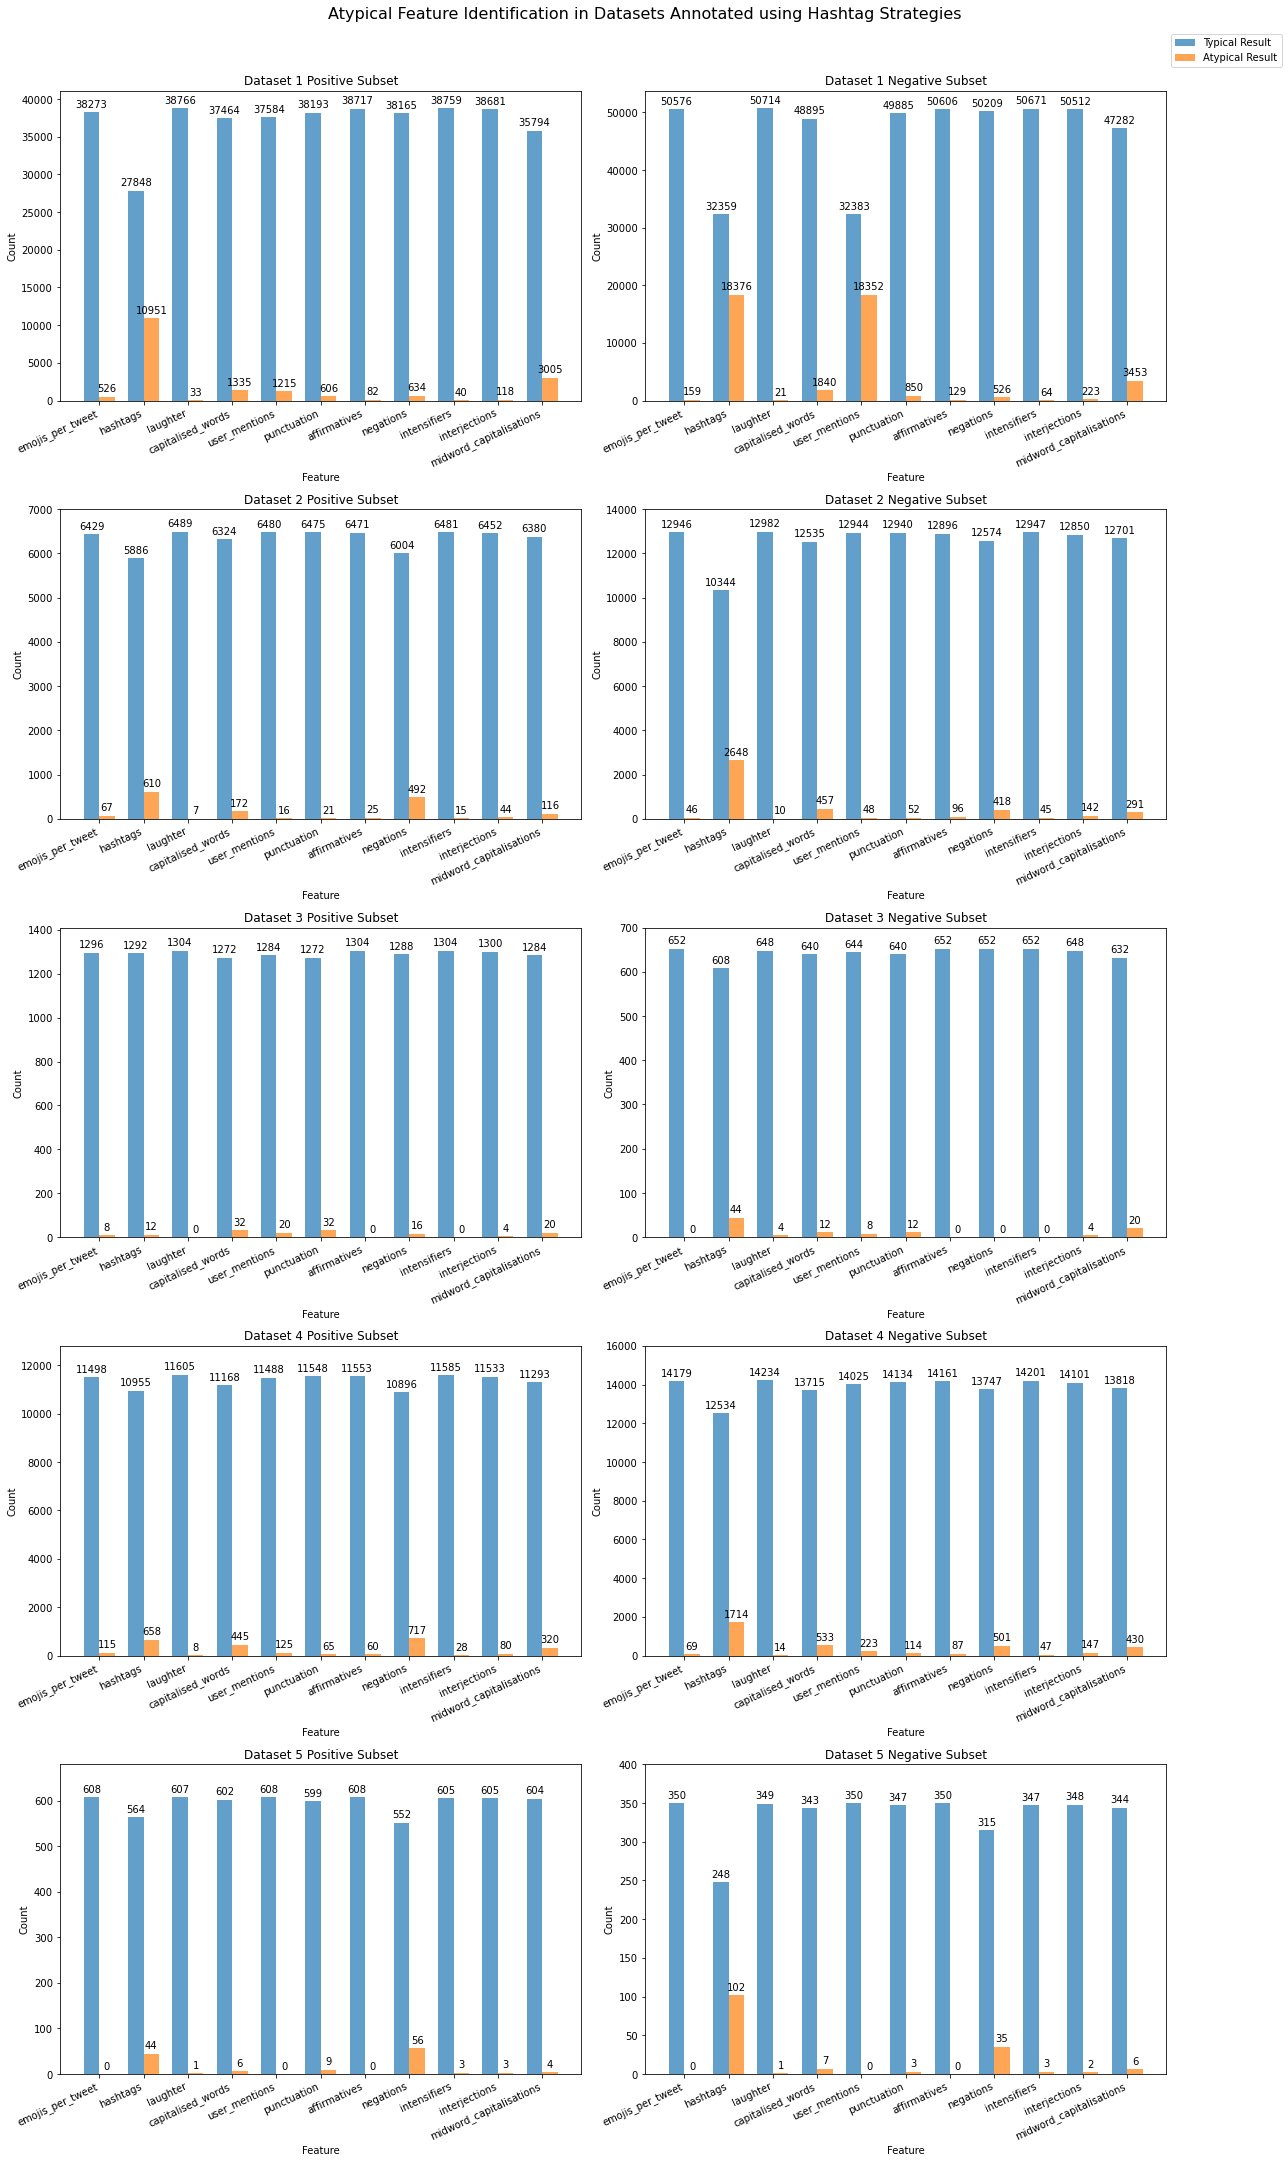

In [382]:
#Create a visualisation to convey the above info

#Define columns for inclusion
selected_columns = ['emojis_per_tweet', 'hashtags', 'laughter',
                   'capitalised_words', 'user_mentions', 'punctuation', 'affirmatives', 'negations', 'intensifiers',
                   'interjections', 'midword_capitalisations']

selected_add_pos = add_pos[selected_columns]
selected_add_neg = add_neg[selected_columns]

selected_add1_pos = add1_pos[selected_columns]
selected_add1_neg = add1_neg[selected_columns]

selected_add2_pos = add2_pos[selected_columns]
selected_add2_neg = add2_neg[selected_columns]

selected_add3_pos = add3_pos[selected_columns]
selected_add3_neg = add3_neg[selected_columns]

selected_add4_pos = add4_pos[selected_columns]
selected_add4_neg = add4_neg[selected_columns]

#Create dfs to store counts for bar charts
counts_add_pos = pd.DataFrame({'Metric': selected_add_pos.columns, 
                               'Yes': selected_add_pos.eq('Yes').sum(), 'No': selected_add_pos.eq('No').sum()})
total_add_pos = len(counts_add_pos)
counts_add_neg = pd.DataFrame({'Metric': selected_add_neg.columns, 
                               'Yes': selected_add_neg.eq('Yes').sum(), 'No': selected_add_neg.eq('No').sum()})
total_add_neg = len(counts_add_neg)


counts_add1_pos = pd.DataFrame({'Metric': selected_add1_pos.columns, 
                               'Yes': selected_add1_pos.eq('Yes').sum(), 'No': selected_add1_pos.eq('No').sum()})
total_add1_pos = len(counts_add1_pos)
counts_add1_neg = pd.DataFrame({'Metric': selected_add1_neg.columns, 
                               'Yes': selected_add1_neg.eq('Yes').sum(), 'No': selected_add1_neg.eq('No').sum()})
total_add1_neg = len(counts_add1_neg)

counts_add2_pos = pd.DataFrame({'Metric': selected_add2_pos.columns, 
                               'Yes': selected_add2_pos.eq('Yes').sum(), 'No': selected_add2_pos.eq('No').sum()})
total_add2_pos = len(counts_add2_pos)
counts_add2_neg = pd.DataFrame({'Metric': selected_add2_neg.columns, 
                               'Yes': selected_add2_neg.eq('Yes').sum(), 'No': selected_add2_neg.eq('No').sum()})
total_add2_neg = len(counts_add2_neg)

counts_add3_pos = pd.DataFrame({'Metric': selected_add3_pos.columns, 
                               'Yes': selected_add3_pos.eq('Yes').sum(), 'No': selected_add3_pos.eq('No').sum()})
total_add3_pos = len(counts_add3_pos)
counts_add3_neg = pd.DataFrame({'Metric': selected_add3_neg.columns, 
                               'Yes': selected_add3_neg.eq('Yes').sum(), 'No': selected_add3_neg.eq('No').sum()})
total_add3_neg = len(counts_add3_neg)

counts_add4_pos = pd.DataFrame({'Metric': selected_add4_pos.columns, 
                               'Yes': selected_add4_pos.eq('Yes').sum(), 'No': selected_add4_pos.eq('No').sum()})
total_add4_pos = len(counts_add4_pos)
counts_add4_neg = pd.DataFrame({'Metric': selected_add4_neg.columns, 
                               'Yes': selected_add4_neg.eq('Yes').sum(), 'No': selected_add4_neg.eq('No').sum()})
total_add4_neg = len(counts_add4_neg)

#Create an array of index values for each metric
x_add_pos = np.arange(total_add_pos)
x_add_neg = np.arange(total_add_neg)

x_add1_pos = np.arange(total_add1_pos)
x_add1_neg = np.arange(total_add1_neg)

x_add2_pos = np.arange(total_add2_pos)
x_add2_neg = np.arange(total_add2_neg)

x_add3_pos = np.arange(total_add3_pos)
x_add3_neg = np.arange(total_add3_neg)

x_add4_pos = np.arange(total_add4_pos)
x_add4_neg = np.arange(total_add4_neg)

#Create a 2x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 30))
fig.subplots_adjust(wspace=0.1, hspace=0.3)

#Create a paired bar charts for each place in the grid
bar_width = 0.35
bar1_add_pos = axes[0, 0].bar(x_add_pos - bar_width/2, counts_add_pos['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add_pos = axes[0, 0].bar(x_add_pos + bar_width/2, counts_add_pos['No'], bar_width, label='Atypical Result', alpha=0.7)
bar1_add_neg = axes[0, 1].bar(x_add_neg - bar_width/2, counts_add_neg['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add_neg = axes[0, 1].bar(x_add_neg + bar_width/2, counts_add_neg['No'], bar_width, label='Atypical Result', alpha=0.7)

bar1_add1_pos = axes[1, 0].bar(x_add1_pos - bar_width/2, counts_add1_pos['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add1_pos = axes[1, 0].bar(x_add1_pos + bar_width/2, counts_add1_pos['No'], bar_width, label='Atypical Result', alpha=0.7)
bar1_add1_neg = axes[1, 1].bar(x_add1_neg - bar_width/2, counts_add1_neg['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add1_neg = axes[1, 1].bar(x_add1_neg + bar_width/2, counts_add1_neg['No'], bar_width, label='Atypical Result', alpha=0.7)

bar1_add2_pos = axes[2, 0].bar(x_add2_pos - bar_width/2, counts_add2_pos['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add2_pos = axes[2, 0].bar(x_add2_pos + bar_width/2, counts_add2_pos['No'], bar_width, label='Atypical Result', alpha=0.7)
bar1_add2_neg = axes[2, 1].bar(x_add2_neg - bar_width/2, counts_add2_neg['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add2_neg = axes[2, 1].bar(x_add2_neg + bar_width/2, counts_add2_neg['No'], bar_width, label='Atypical Result', alpha=0.7)

bar1_add3_pos = axes[3, 0].bar(x_add3_pos - bar_width/2, counts_add3_pos['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add3_pos = axes[3, 0].bar(x_add3_pos + bar_width/2, counts_add3_pos['No'], bar_width, label='Atypical Result', alpha=0.7)
bar1_add3_neg = axes[3, 1].bar(x_add3_neg - bar_width/2, counts_add3_neg['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add3_neg = axes[3, 1].bar(x_add3_neg + bar_width/2, counts_add3_neg['No'], bar_width, label='Atypical Result', alpha=0.7)

bar1_add4_pos = axes[4, 0].bar(x_add4_pos - bar_width/2, counts_add4_pos['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add4_pos = axes[4, 0].bar(x_add4_pos + bar_width/2, counts_add4_pos['No'], bar_width, label='Atypical Result', alpha=0.7)
bar1_add4_neg = axes[4, 1].bar(x_add4_neg - bar_width/2, counts_add4_neg['Yes'], bar_width, label='Typical Result', alpha=0.7)
bar2_add4_neg = axes[4, 1].bar(x_add4_neg + bar_width/2, counts_add4_neg['No'], bar_width, label='Atypical Result', alpha=0.7)

#Add counts above the bars
for bar in bar1_add_pos + bar2_add_pos:
    height = bar.get_height()
    axes[0, 0].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
for bar in bar1_add_neg + bar2_add_neg:
    height = bar.get_height()
    axes[0, 1].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')

for bar in bar1_add1_pos + bar2_add1_pos:
    height = bar.get_height()
    axes[1, 0].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
for bar in bar1_add1_neg + bar2_add1_neg:
    height = bar.get_height()
    axes[1, 1].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
    
for bar in bar1_add2_pos + bar2_add2_pos:
    height = bar.get_height()
    axes[2, 0].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
for bar in bar1_add2_neg + bar2_add2_neg:
    height = bar.get_height()
    axes[2, 1].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')

for bar in bar1_add3_pos + bar2_add3_pos:
    height = bar.get_height()
    axes[3, 0].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
for bar in bar1_add3_neg + bar2_add3_neg:
    height = bar.get_height()
    axes[3, 1].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
    
for bar in bar1_add4_pos + bar2_add4_pos:
    height = bar.get_height()
    axes[4, 0].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
for bar in bar1_add4_neg + bar2_add4_neg:
    height = bar.get_height()
    axes[4, 1].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')

#Add suptitle 
fig.suptitle('Atypical Feature Identification in Datasets Annotated using Hashtag Strategies', fontsize=16, y=1.0)

#Define configuration of plots
axes[0, 0].set_xlabel('Feature')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_ylim(0, 41100)
axes[0, 0].set_title('Dataset 1 Positive Subset')
axes[0, 0].set_xticks(x_add_pos)
axes[0, 0].set_xticklabels(counts_add_pos['Metric'], rotation=25, ha='right')

axes[0, 1].set_xlabel('Feature')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_ylim(0, 53750)
axes[0, 1].set_title('Dataset 1 Negative Subset')
axes[0, 1].set_xticks(x_add_neg)
axes[0, 1].set_xticklabels(counts_add_neg['Metric'], rotation=25, ha='right')
axes[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1.2))

axes[1, 0].set_xlabel('Feature')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_ylim(0, 7000)
axes[1, 0].set_title('Dataset 2 Positive Subset')
axes[1, 0].set_xticks(x_add1_pos)
axes[1, 0].set_xticklabels(counts_add1_pos['Metric'], rotation=25, ha='right')

axes[1, 1].set_xlabel('Feature')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_ylim(0, 14000)
axes[1, 1].set_title('Dataset 2 Negative Subset')
axes[1, 1].set_xticks(x_add1_neg)
axes[1, 1].set_xticklabels(counts_add1_neg['Metric'], rotation=25, ha='right')

axes[2, 0].set_xlabel('Feature')
axes[2, 0].set_ylabel('Count')
axes[2, 0].set_ylim(0, 1410)
axes[2, 0].set_title('Dataset 3 Positive Subset')
axes[2, 0].set_xticks(x_add2_pos)
axes[2, 0].set_xticklabels(counts_add2_pos['Metric'], rotation=25, ha='right')

axes[2, 1].set_xlabel('Feature')
axes[2, 1].set_ylabel('Count')
axes[2, 1].set_ylim(0, 700)
axes[2, 1].set_title('Dataset 3 Negative Subset')
axes[2, 1].set_xticks(x_add2_neg)
axes[2, 1].set_xticklabels(counts_add2_neg['Metric'], rotation=25, ha='right')

axes[3, 0].set_xlabel('Feature')
axes[3, 0].set_ylabel('Count')
axes[3, 0].set_ylim(0, 12800)
axes[3, 0].set_title('Dataset 4 Positive Subset')
axes[3, 0].set_xticks(x_add3_pos)
axes[3, 0].set_xticklabels(counts_add3_pos['Metric'], rotation=25, ha='right')

axes[3, 1].set_xlabel('Feature')
axes[3, 1].set_ylabel('Count')
axes[3, 1].set_ylim(0, 16000)
axes[3, 1].set_title('Dataset 4 Negative Subset')
axes[3, 1].set_xticks(x_add3_neg)
axes[3, 1].set_xticklabels(counts_add3_neg['Metric'], rotation=25, ha='right')

axes[4, 0].set_xlabel('Feature')
axes[4, 0].set_ylabel('Count')
axes[4, 0].set_ylim(0, 680)
axes[4, 0].set_title('Dataset 5 Positive Subset')
axes[4, 0].set_xticks(x_add4_pos)
axes[4, 0].set_xticklabels(counts_add4_pos['Metric'], rotation=25, ha='right')

axes[4, 1].set_xlabel('Feature')
axes[4, 1].set_ylabel('Count')
axes[4, 1].set_ylim(0, 400)
axes[4, 1].set_title('Dataset 5 Negative Subset')
axes[4, 1].set_xticks(x_add4_neg)
axes[4, 1].set_xticklabels(counts_add4_neg['Metric'], rotation=25, ha='right')

plt.tight_layout()
plt.show()

In [384]:
#Define values for paired bar chart 
add_pos_typ = 14775
add_pos_atyp = 24024
add_neg_typ = 5747
add_neg_atyp = 44988
add_overall_typ = add_pos_typ + add_neg_typ
add_overall_atyp = add_pos_atyp + add_neg_atyp

add1_pos_typ = 2736
add1_pos_atyp = 3760
add1_neg_typ = 47
add1_neg_atyp = 12945
add1_overall_typ = add1_pos_typ + add1_neg_typ
add1_overall_atyp = add1_pos_atyp + add1_neg_atyp

add2_pos_typ = 876
add2_pos_atyp = 428
add2_neg_typ = 380
add2_neg_atyp = 272
add2_overall_typ = add2_pos_typ + add2_neg_typ
add2_overall_atyp = add2_pos_atyp + add2_neg_atyp

add3_pos_typ = 6216
add3_pos_atyp = 5397
add3_neg_typ = 7480
add3_neg_atyp = 6768
add3_overall_typ = add3_pos_typ + add3_neg_typ
add3_overall_atyp = add3_pos_atyp + add3_neg_atyp

add4_pos_typ = 251
add4_pos_atyp = 357
add4_neg_typ = 85
add4_neg_atyp = 350
add4_overall_typ = add4_pos_typ + add4_neg_typ
add4_overall_atyp = add4_pos_atyp + add4_neg_atyp

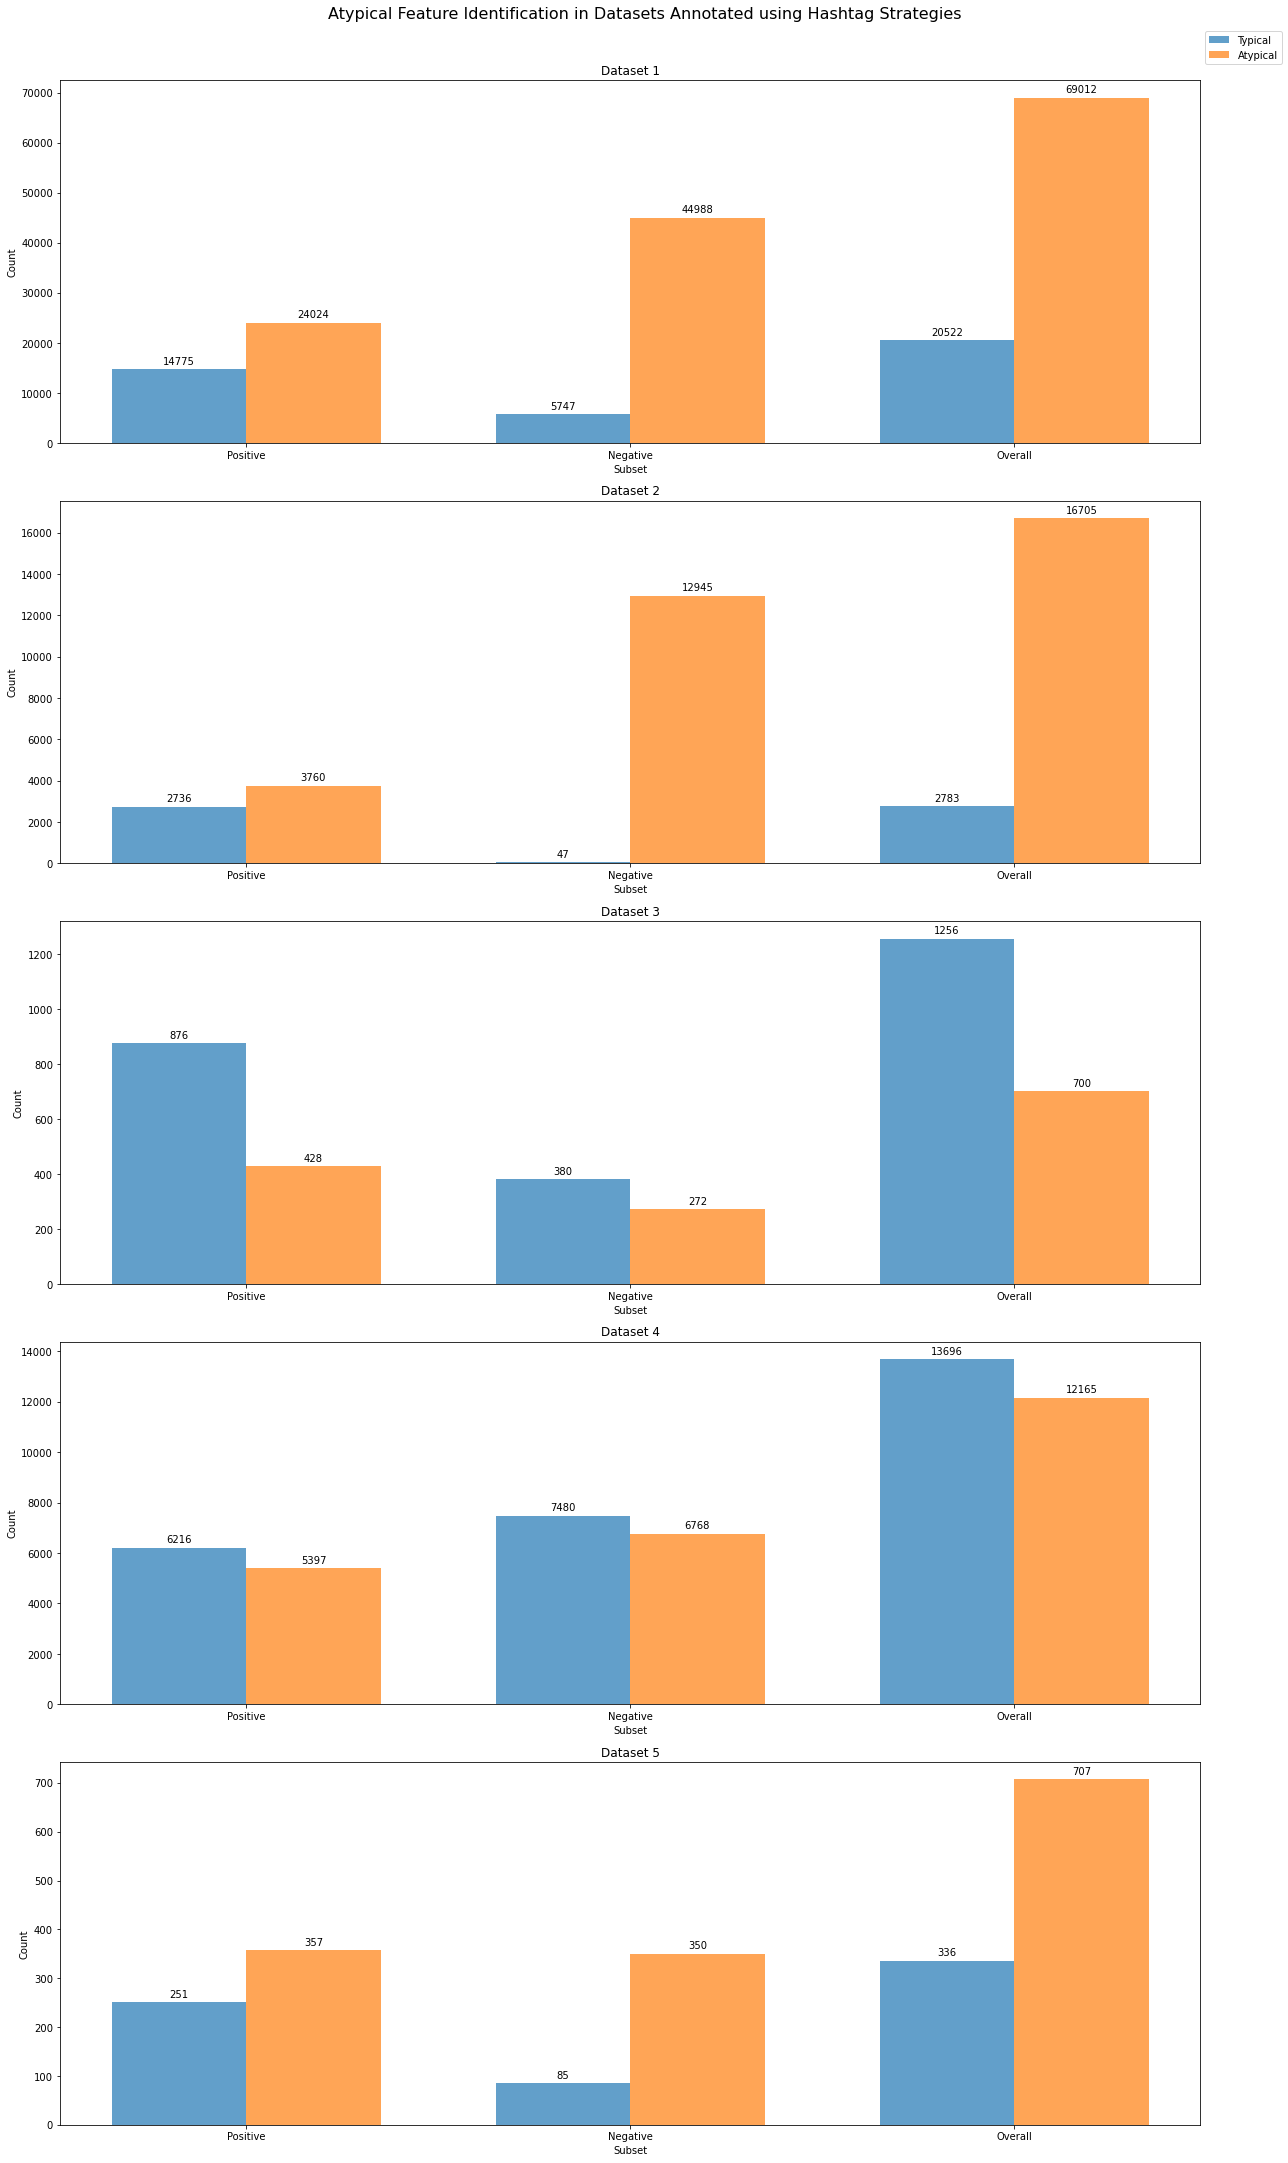

In [399]:
#Define the data
metrics = ['Positive', 'Negative', 'Overall']
typ_df = [add_pos_typ, add_neg_typ, add_overall_typ]
atyp_df = [add_pos_atyp, add_neg_atyp, add_overall_atyp]

typ_df1 = [add1_pos_typ, add1_neg_typ, add1_overall_typ]
atyp_df1 = [add1_pos_atyp, add1_neg_atyp, add1_overall_atyp]

typ_df2 = [add2_pos_typ, add2_neg_typ, add2_overall_typ]
atyp_df2 = [add2_pos_atyp, add2_neg_atyp, add2_overall_atyp]

typ_df3 = [add3_pos_typ, add3_neg_typ, add3_overall_typ]
atyp_df3 = [add3_pos_atyp, add3_neg_atyp, add3_overall_atyp]

typ_df4 = [add4_pos_typ, add4_neg_typ, add4_overall_typ]
atyp_df4 = [add4_pos_atyp, add4_neg_atyp, add4_overall_atyp]

# Set the width of the bars
bar_width = 0.35
index = np.arange(len(metrics))

#Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(18, 30))

# Create bars for plots
bar1_typ_df = axes[0].bar(index - bar_width/2, typ_df, bar_width, label='Typical', alpha=0.7)
bar2_atyp_df = axes[0].bar(index + bar_width/2, atyp_df, bar_width, label='Atypical', alpha=0.7)

bar1_typ_df1 = axes[1].bar(index - bar_width/2, typ_df1, bar_width, label='Typical', alpha=0.7)
bar2_atyp_df1 = axes[1].bar(index + bar_width/2, atyp_df1, bar_width, label='Atypical', alpha=0.7)

bar1_typ_df2 = axes[2].bar(index - bar_width/2, typ_df2, bar_width, label='Typical', alpha=0.7)
bar2_atyp_df2 = axes[2].bar(index + bar_width/2, atyp_df2, bar_width, label='Atypical', alpha=0.7)

bar1_typ_df3 = axes[3].bar(index - bar_width/2, typ_df3, bar_width, label='Typical', alpha=0.7)
bar2_atyp_df3 = axes[3].bar(index + bar_width/2, atyp_df3, bar_width, label='Atypical', alpha=0.7)

bar1_typ_df4 = axes[4].bar(index - bar_width/2, typ_df4, bar_width, label='Typical', alpha=0.7)
bar2_atyp_df4 = axes[4].bar(index + bar_width/2, atyp_df4, bar_width, label='Atypical', alpha=0.7)

#Add suptitle
fig.suptitle('Atypical Feature Identification in Datasets Annotated using Hashtag Strategies', fontsize=16, y=1.0)

#Add counts above the bars
for bar in bar1_typ_df + bar2_atyp_df:
    height = bar.get_height()
    axes[0].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
for bar in bar1_typ_df1 + bar2_atyp_df1:
    height = bar.get_height()
    axes[1].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
    
for bar in bar1_typ_df2 + bar2_atyp_df2:
    height = bar.get_height()
    axes[2].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')

for bar in bar1_typ_df3 + bar2_atyp_df3:
    height = bar.get_height()
    axes[3].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')

for bar in bar1_typ_df4 + bar2_atyp_df4:
    height = bar.get_height()
    axes[4].annotate('{}'.format(height),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), 
                       textcoords="offset points",
                       ha='center', va='bottom')
    
#Define configuration of plots
axes[0].set_xlabel('Subset')
axes[0].set_ylabel('Count')
axes[0].set_title('Dataset 1')
axes[0].set_xticks(index)
axes[0].set_xticklabels(metrics)
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1.15))

axes[1].set_xlabel('Subset')
axes[1].set_ylabel('Count')
axes[1].set_title('Dataset 2')
axes[1].set_xticks(index)
axes[1].set_xticklabels(metrics)

axes[2].set_xlabel('Subset')
axes[2].set_ylabel('Count')
axes[2].set_title('Dataset 3')
axes[2].set_xticks(index)
axes[2].set_xticklabels(metrics)

axes[3].set_xlabel('Subset')
axes[3].set_ylabel('Count')
axes[3].set_title('Dataset 4')
axes[3].set_xticks(index)
axes[3].set_xticklabels(metrics)

axes[4].set_xlabel('Subset')
axes[4].set_ylabel('Count')
axes[4].set_title('Dataset 5')
axes[4].set_xticks(index)
axes[4].set_xticklabels(metrics)

# Adjust layout
plt.tight_layout()
plt.show()


# Remove atypical data from each df

In [402]:
#Generate subsets of each df containing only the typical text
add_pos_typical = add_pos[add_pos['no_count'] == 0]
add_neg_typical = add_neg[add_neg['no_count'] == 0]

add1_pos_typical = add1_pos[add1_pos['no_count'] == 0]
add1_neg_typical = add1_neg[add1_neg['no_count'] == 0]

add2_pos_typical = add2_pos[add2_pos['no_count'] == 0]
add2_neg_typical = add2_neg[add2_neg['no_count'] == 0]

add3_pos_typical = add3_pos[add3_pos['no_count'] == 0]
add3_neg_typical = add3_neg[add3_neg['no_count'] == 0]

add4_pos_typical = add4_pos[add4_pos['no_count'] == 0]
add4_neg_typical = add4_neg[add4_neg['no_count'] == 0]

In [403]:
#Combine them into one master df
add_overall = pd.concat([add_pos_typical, add_neg_typical, add1_pos_typical, add1_neg_typical,
                        add2_pos_typical, add2_neg_typical, add3_pos_typical, add3_neg_typical,
                        add4_pos_typical, add4_neg_typical], ignore_index=True)

#Check shape
add_overall.shape

(38593, 21)

In [407]:
#Check format
add_overall.head()

,text,label,sentiment_result,sentiment_label,emojis_per tweet,emojis_per_tweet,sent_score,pred_pos,pred_neg,pred_neut,...,laughter,capitalised_words,user_mentions,punctuation,affirmatives,negations,intensifiers,interjections,midword_capitalisations,no_count
0,@raaachf for the car ride when I get to listen...,1,"[0.004537248983979225, 0.056863728910684586, 0...",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
1,Aamir calls #BajrangiBhaijaan as Salman's best...,1,"[0.015803156420588493, 0.35204407572746277, 0....",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
2,You keep them close to see what they're up to....,1,"[0.0733950212597847, 0.6475877165794373, 0.279...",positive,Yes,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
3,@Hotwire Thanks for giving my personal informa...,1,"[0.002137369243428111, 0.01833817921578884, 0....",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0
4,It's only been out for 2 years though I'm sure...,1,"[0.10774402320384979, 0.46555668115615845, 0.4...",positive,Yes,Yes,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,0


In [409]:
#Drop unnecessary columns
classification_cols = ['text', 'label']
add_overall = add_overall[classification_cols]

#Combine with the nonsarcastic data
add_final = pd.concat([add_overall, add_overall_nonsarc], ignore_index=True)

#Check contents
add_final['label'].value_counts()

label
0    52270
1    38593
Name: count, dtype: int64

In [410]:
#Save as csv
add_final.to_csv('typical_tweets_found.csv', index=False)

# Format data for cleaning

In [521]:
#Importing dataset validated data
df_1 = pd.read_csv('validated_tweets.csv')
df_1.head()

,tweet,label
0,The only thing I got from college was a caffei...,1
1,"""My (extended) fam was discussing going on a t...",1
2,i love shoegaze sm 😁,1
3,men are so grimey 😢,1
4,okay but like the say so song aint that bad. I...,1


In [522]:
#Importing dataset filtered data
df_2 = pd.read_csv('typical_tweets_found.csv')
df_2.head()

,text,label
0,@raaachf for the car ride when I get to listen...,1
1,Aamir calls #BajrangiBhaijaan as Salman's best...,1
2,You keep them close to see what they're up to....,1
3,@Hotwire Thanks for giving my personal informa...,1
4,It's only been out for 2 years though I'm sure...,1


In [523]:
#Rename columns to combine the data
df_1.rename(columns={'tweet': 'text'}, inplace=True)

In [524]:
#Add column to track where data originated
df_1['source'] = 'val'
df_2['source'] = 'filter'

In [692]:
#Combine data
df = pd.concat([df_1, df_2], ignore_index=True)
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [693]:
#Check for null values
df.isnull().sum()

text      11
label      0
source     0
dtype: int64

In [694]:
#Drop the nulls
df.dropna(inplace=True)
df.isnull().sum()

text      0
label     0
source    0
dtype: int64

In [695]:
#Check balance of data
df['label'].value_counts()

label
0    55154
1    39692
Name: count, dtype: int64

In [696]:
#Balance the data between labels

#Create a mask to randomly sample from the non-sarcastic data only
mask = (df['label'] == 0)

#Get the indices of rows that meet the criteria
indices_to_remove = df[mask].sample(n=15462, random_state=42).index

#Remove the data
df = df.drop(indices_to_remove)

#Check balance of data
df['label'].value_counts()

label
1    39692
0    39692
Name: count, dtype: int64

In [531]:
#Save as csv
df.to_csv('all_training_final.csv', index=False)

In [624]:
#Break data down for processing- it is taking too much memory to process at present
df_label_0 = df[df['label'] == 0]
df_label_1 = df[df['label'] == 1]

#Take the first 500 rows of each subset to test pipeline initially
ss_0 = df_label_0.iloc[:500]
ss_1 = df_label_1.iloc[:500]

ss_0.shape, ss_1.shape

((500, 3), (500, 3))

In [625]:
#Combine the data for processing
ss = pd.concat([ss_1, ss_0], ignore_index=True)
ss.shape

(1000, 3)

In [626]:
#Look at data format
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


# Text Cleaning

In [634]:
#Importing libraries
import re, os, itertools, string
from collections import Counter
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import words
import numpy as np
import emoji
import utils
import time, os, utils
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer

In [481]:
#Read in word list
word_list = pd.read_csv('word_list.txt')

In [666]:
#Functions used in initial preprocessing steps

#Define a function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

#Define a function to split hashtags within text
def split_hashtags_in_text(text):
    def split_hashtag(hashtag):
        split_words = []
        if hashtag != hashtag.lower() and hashtag != hashtag.upper():
            split_words = camel_case_split(hashtag)
        else:
            j = 0
            while j <= len(hashtag):
                loc = j
                for i in range(j + 1, len(hashtag) + 1, 1):
                    if hashtag[j:i].lower() in word_list:
                        loc = i
                if loc == j:
                    j += 1
                else:
                    split_words.append(hashtag[j:loc])
                    j = loc
        split_words = ['#' + str(s) for s in split_words]
        return split_words

    def camel_case_split(term):
        term = re.sub(r'([0-9]+)', r' \1', term)
        term = re.sub(r'(1st|2nd|3rd|4th|5th|6th|7th|8th|9th|0th)', r'\1 ', term)
        splits = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', term)
        return [s.group(0) for s in splits]

    #Find hashtags within the text using regex
    hashtags = re.findall(r'#\w+', text)
    
    #Split and flatten the hashtags
    split_hashtags = [split_hashtag(tag) for tag in hashtags]
    split_hashtags = [item for sublist in split_hashtags for item in sublist]
    
    #Replace the original hashtags in the text with the split words
    for hashtag in hashtags:
        text = text.replace(hashtag, ' '.join(split_hashtag(hashtag)))
    return text

#Define function to replace emoticons with emojis
def replace_emoticons(text, emoticons_to_emojis_dict):
    #Iterate through the dictionary and replace each emoticon with its corresponding emoji
    for emoticon, emoji in emoticons_to_emojis_dict.items():
        text = text.replace(emoticon, emoji)
    return text

In [697]:
#Dictionary used in initial preprocessing steps 
emoticons_to_emojis = {
    ':{': '😞', ':c)': '😃', ':-||': '😞', ':(': '😞', ':-))': '😂', 'dx': '😧',
    ':-d': '😀', '))': '😂', ':-*': '😗', ':d': '😀', ":'((": '😢', ':‑Þ': '😛',
    ':-[': '😞', ':-<': '😞', ":'-)": '😂', ":'-(": '😢', ':þ': '😛', ':‑,': '😉',
    '=]': '😃', '>:[': '😞', ':Þ': '😛', ':‑|': '😐', 'd8': '😧', 'O:‑)': '😃',
    ';)': '😉', ':‑b': '😛', ":')": '😂', '>:(': '😞', '8-0': '😲', ';-)': '😃',
    ':o)': '😲', ':‑þ': '😛', ':o': '😲', ':-)': '😃', ':-o': '😲', '(-:': '😃',
    ';d': '😉', ':))': '😂', ':x': '😗', ';^)': '😉', '(:': '😃', ':$': '😳', 'd;': '😧',
    'd:<': '😧', ':O': '😲', ':-c': '😞', 'xoxo': '💋', ':‑p': '😛', '8)': '😃',
    '0:)': '😃', '0;^)': '😃', ':@': '😞', 'xx': '♥', ':-}': '😃', '::': '😕', ';‑)': '😉',
    'xx': '♥', ':-]': '😃', ':*': '😗', ':-(': '😞', ']]': '😂', '\\m/': '🎶', '*)': '😉',
    ':}': '😃', ':)': '😃', '=/': '😕', ';;': '😕', '>:o': '😲', '=d': '😀', ':L': '😕',
    ':((': '😢', '=3': '😀', '0:‑)': '😃', ':-O': '😲', ':<': '😞', 'd=': '😧', '0:3': '😃',
    ';]': '😉', ';p': '😛', ':P': '😛', 'x‑p': '😛', '=)': '😃', 'O:)': '😃', ':p': '😛',
    'x-d': '😀', '8-)': '😃', ':S': '😕', "d-':": '😧', ':c': '😞', ':|': '😐', '0:‑3': '😃',
    '>:p': '😛', '>:\\': '😕', ':/': '😕', ':]': '😃', ':3': '😃', ':b': '😛', ';‑]': '😉',
    '8d': '😀', 'xo': '💋', '>:/': '😕', '((': '😢', ':[': '😞', ':‑/': '😕', ':->': '😃',
    ';(': '😞', '=))': '😂', '=\\': '😕', ":'(": '😢', '*-)': '😉', ':\\': '😕', 'xd': '😀',
    'xp': '😛', ':-3': '😃', '=l': '😕', ':^)': '😃', '=p': '😛', ':>': '😃', '8-d': '😀',
    ':-0': '😲', 'd:': '😛', ':‑.': '😕'}

In [587]:
#Convert text to strings
ss['text'] = ss['text'].astype(str)
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [669]:
#Test the emoji to emoticon function

#Replace emoticons with emojis
text_with_emoticons = "I'm feeling so happy today! :)"
cleaned_text = replace_emoticons(text_with_emoticons, emoticons_to_emojis)
print(cleaned_text)

I'm feeling so happy today! 😃


In [588]:
#Replace special characters with spaces
ss['text'] = ss['text'].apply(lambda text: re.sub('([!?*&%"~`^+{}])', r' \1 ', text))
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,""" My (extended) fam was discussing going on a...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [589]:
#Replace consecutive spaces with a single space
ss['text'] = ss['text'].apply(lambda text: re.sub('\s{2,}', ' ', text))
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,""" My (extended) fam was discussing going on a...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [590]:
#Filter and keep valid tokens
for index, row in ss.iterrows():
    text = row['text']
    
    tokens = text.split()
    valid_tokens = [token for token in tokens if len(token) > 0]
    
    processed_text = ' '.join(valid_tokens)
    ss.at[index, 'text'] = processed_text
    
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,""" My (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [592]:
#Remove any hashtags relating to sarcasm
ss['text'] = ss['text'].str.replace(r'\b\w*\.lower\(\)\.startswith\(\'#sarca\'\)\b', '', regex=True)
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,""" My (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [593]:
#Remove all URLs
ss['text'] = ss['text'].apply(remove_urls)
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,""" My (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [673]:
#Test the @user function

#Generate test content
test = ['hello, @mary']

#Replace user mentions with a generic @user
for i in range(len(test)):
    test[i] = re.sub(r'@\w+', '@user', test[i])
print(test)

['hello, @user']


In [595]:
#Split hashtags into words
ss['text'] = ss['text'].apply(split_hashtags_in_text)
ss.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,""" My (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [596]:
#Make all words lowercase
ss['text'] = ss['text'].str.lower()
ss.head()

,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,""" my (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. i...,1,val


In [600]:
#Look at some of the rows
ss['text'].iloc[76]

'do you think anyone on bachelor in paradise has seen oscar winner parasite ? 😳'

In [698]:
#Apply the replace emoticons with emojis before any preprocessing-maximises the amount in the df
for index, row in df.iterrows():
    df.at[index, 'text'] = replace_emoticons(row['text'], emoticons_to_emojis)
df.head()

,text,label,source
0,The only thing I got from college was a caffei...,1,val
1,"""My (extended) fam was discussing going on a t...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. I...,1,val


In [688]:
#Define function to process more data in the same way
def clean_text_dataframe(dataframe):
    #Convert 'text' column to strings
    dataframe['text'] = dataframe['text'].astype(str)
    print('Step 1 complete.')
    
    # Replace special characters with spaces
    dataframe['text'] = dataframe['text'].apply(lambda text: re.sub('([!?*&%"~`^+{}])', r' \1 ', text))
    print('Step 2 complete.')
    
    # Replace consecutive spaces with a single space
    dataframe['text'] = dataframe['text'].apply(lambda text: re.sub('\s{2,}', ' ', text))
    print('Step 3 complete.')
    
    # Iterate through each row and process the 'text' column
    for index, row in dataframe.iterrows():
        text = row['text']
    
        tokens = text.split()
        valid_tokens = [token for token in tokens if len(token) > 0]
    
        processed_text = ' '.join(valid_tokens)
        dataframe.at[index, 'text'] = processed_text
    print('Step 4 complete.')
    
    # Remove any hashtags relating to sarcasm
    dataframe['text'] = dataframe['text'].str.replace(r'\b\w*\.lower\(\)\.startswith\(\'#sarca\'\)\b', '', regex=True)
    print('Step 5 complete.')
    
    # Remove all URLs
    dataframe['text'] = dataframe['text'].apply(remove_urls)
    print('Step 6 complete.')
    
    # Replace user mentions with a generic @user
    dataframe['text'] = dataframe['text'].str.replace(r'@\w+', '@user', regex=True)
    print('Step 7 complete.')
    
    # Split hashtags into words
    dataframe['text'] = dataframe['text'].apply(split_hashtags_in_text)
    print('Step 8 complete.')
    
    # Make all words lowercase
    dataframe['text'] = dataframe['text'].str.lower()
    print('Step 9 complete.')
    
    return dataframe

In [628]:
#Test the function
ss = clean_text_dataframe(ss)
ss.head()

Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.
Step 9 complete.


,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,""" my (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. i...,1,val


In [699]:
#Apply the function to the overall df
df = clean_text_dataframe(df)
df.head()

Step 1 complete.
Step 2 complete.
Step 3 complete.
Step 4 complete.
Step 5 complete.
Step 6 complete.
Step 7 complete.
Step 8 complete.
Step 9 complete.


,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,""" my (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm 😁,1,val
3,men are so grimey 😢,1,val
4,okay but like the say so song aint that bad. i...,1,val


In [700]:
#Make secondary subsets to perform different cleaning processes
df_clean_a = df.copy()

In [635]:
#Get stopwords
stopwords = set(stopwords.words('english'))

#Define function to remove stopwords from the text
def remove_stopwords(text):
    #Tokenize the text into words
    words = text.split()
    #Filter out stopwords
    words = [word for word in words if word.lower() not in stopwords]
    #Join the remaining words back into a string
    return ' '.join(words)

#Get lemmatiser
lemmatizer = WordNetLemmatizer()

#Define function to lemmatise the text
def lemmatize_text(text):
    lemmatized_tokens = []
    for token in text.split():
        token = token.lower()
        #Attempt lemmatization as a verb first
        lemmatized_token = lemmatizer.lemmatize(token, 'v')
        #If verb lemmatization doesn't work, try general lemmatization
        lemmatized_token = lemmatizer.lemmatize(lemmatized_token)
        lemmatized_tokens.append(lemmatized_token)
    return ' '.join(lemmatized_tokens)

In [638]:
#Test remove stopwords function on the small sample set
for index, row in ss.iterrows():
    ss.at[index, 'text'] = remove_stopwords(row['text'])
ss['text'].iloc[0]

'thing got college caffeine addiction 😏'

In [642]:
#Test lemmatise function on small sample set
for index, row in ss.iterrows():
    ss.at[index, 'text'] = lemmatize_text(row['text'])
ss['text'].iloc[10]

'see brexit go well'

In [646]:
#Define a function to apply these processing steps in a sequence
def clean_stopwords_lemmatize(dataframe):
    for index, row in dataframe.iterrows():
        dataframe.at[index, 'text'] = remove_stopwords(row['text'])
    print('Step 1 Complete.')
    
    for index, row in dataframe.iterrows():
        dataframe.at[index, 'text'] = lemmatize_text(row['text'])
        print('Step 2 Complete.')
        return dataframe

In [701]:
#Apply the function to the overall df
df_clean_a = clean_stopwords_lemmatize(df_clean_a)
df_clean_a.head()

Step 1 Complete.
Step 2 Complete.


,text,label,source
0,thing get college caffeine addiction 😏,1,val
1,""" (extended) fam discussing going trip instead...",1,val
2,love shoegaze sm 😁,1,val
3,men grimey 😢,1,val
4,okay like say song aint bad. im unironically j...,1,val


In [722]:
#Perform a more strict clean on the data
#Remove hyphens (outside words), replace slang and contractions with long form words
#Contracts repeating characters

#Define function to remove hyphens that are not within words
def remove_unnecessary_hyphens(text):
    #An unnecessary hyphen is one that is not preceded or followed by an alphabetic character
    pattern = r'(?<![a-zA-Z])-|-(?![a-zA-Z])'
    #Use re.sub to replace unnecessary hyphens with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

#Define a function to replace contractions with the long form equivalent
def replace_contractions(text, contractions_dict):
    #Split the text into words
    words = text.split()
    #Initialize an empty list to store the cleaned words
    cleaned_words = []
    #Iterate through each word in the text
    for word in words:
        #Check if the word is in the contractions dictionary
        if word.lower() in contractions_dict:
            #Replace the contraction with its long-form equivalent
            long_form = contractions_dict[word.lower()]
            #Append the long form to the cleaned words list
            cleaned_words.append(long_form)
        else:
            #If not a contraction, keep the word as is
            cleaned_words.append(word)
    #Reconstruct the text with cleaned words
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

#Define a function to replace slang with the long form equivalent
def replace_slang(text, slang_dict):
    #Split the text into words
    words = text.split()
    #Initialize an empty list to store the cleaned words
    cleaned_words = []
    #Iterate through each word in the text
    for word in words:
        #Check if the word is in the slang dictionary
        if word.lower() in slang_dict:
            #Replace slang word with its long form
            long_form = slang_dict[word.lower()]
            #Append the long form to the cleaned words list
            cleaned_words.append(long_form)
        else:
            #If not in slang dictionary, keep the word as is
            cleaned_words.append(word)
    #Reconstruct the text with cleaned words
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

#Define a function to remove repeating characters in text when not in a valid word
def process_repeating_characters(text):
    #Tokenize the input text into individual words
    tokens = text.split()
    def reduce_repeating_characters(token):
        #Define a regular expression pattern to match repeated characters (excluding in vocab cases)
        pattern = r'(\w)\1+'
        #Function to handle the replacement of repeated characters
        def reduce(match):
            return match.group(1) 
        #Skip reduction for tokens with specific conditions (e.g., if they contain certain words)
        if any(word in token.lower() for word in word_list):
            return token
        #Apply the regular expression replacement
        reduced_token = re.sub(pattern, reduce, token)
        return reduced_token
    #Process each token and store the results
    processed_tokens = [reduce_repeating_characters(token) for token in tokens]
    #Reconstruct the text with processed tokens
    processed_text = ' '.join(processed_tokens)
    return processed_text

In [718]:
#Test unnecessary hypens function
test = "End-user - test."
cleaned_text = remove_unnecessary_hyphens(test)
print(cleaned_text) #Need to reapply the function for consecutive spaces after this is used

End-user  test.


In [719]:
#Dictionaries to replace contractions and slang with long form words

#From wikipedia
contractions = {
    "ain't": "is not","aren't": "are not","can't": "cannot","ve": "have","cause": "because","could've": "could have",
    "couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not",
    "hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","ll": "will","n": "and","s": "is",
    "d": "would",  "m": "am","isn't": "is not","it'd": "it would","it'd've": "it would have","let's": "let us","all's": "all",
    "ma'am": "madam","b'day": "birthday","might've": "might have","must've": "must have","mustn't": "must not",
    "mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock",
    "oughtn't": "ought not","oughtn't've": "ought not have","she'll": "she will","she'd": "she would","he'd": "he would",
    "i'd": "I would","i'm": "I am","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have",
    "should've": "should have", "shouldn't": "should not","shouldn't've": "should not have","that'd": "that would", 
    "that's": "that is","there'd": "there would", "there'd've": "there would have","there's": "there is","to've": "to have",
    "wasn't": "was not","re": "are","weren't": "were not","what'll": " what will","what'll've": "what will have",
    "what're": "what are","they're": "they are","what's": "what is","what've": "what have","when's": "when is",
    "when've": "when have","where'd": "where did","where's": "where is","where've": "where have","who'll": " who will",
    "who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is","why've": "why have",
    "will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
    "wouldn't've": "would not have","y'all": "you all","y'll": "you all","ya'll": "you all","y'all'd": "you all would",
    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","c'mon": "come on",
    "ma": "am going to"}

slang = {"4ward": "forward","brb": "be right back","b4": "before","bfn": "bye for now","bgd": "background","btw": "by the way",
         "br": "best regards","clk": "click","da": "the","deet": "detail","deets": "details","dm": "direct message",
         "f2f": "face to face","ftl": " for the loss","ftw": "for the win","kk" : "cool cool","kewl": "cool","rt": "retweet",
         "smh": "so much hate","yaass": "yes","a$$":"ass","bby": "baby","bc": "because","coz": "because","cuz": "because",
         "cause": "because","cmon": "come on","cmonn": "come on","dafuq": "what the fuck","dafuk": "what the fuck",
         "dis": "this","diss": "this","ma": "my","dono": "do not know","donno": "do not know","dunno": "do not know",
         "fb": "facebook","couldnt": "could not","n": "and","gtg": "got to go","yep": "yes","yw": "you are welcome",
         "im": "i am","youre":"you are","hes": "he is","shes": "she is","theyre": "they are","af": "as fuck","fam": "family",
         "fwd": "forward","ffs": "for fuck sake","fml": "fuck my life","lol": "laugh out loud","lel": "laugh out loud",
         "lool": "laugh out loud","lmao": "laugh my ass off","lmaoo": "laugh my ass off","omg":"oh my god","oomg":"oh my god",
         "omgg":"oh my god","omfg": "oh my fucking god","stfu": "shut the fuck up","awsome":"awesome","imo": "in my opinion",
         "imho": "in my humble opinion","ily": "i love you","ilyy": "i love you","ikr": "i know right","ikrr": "i know right",
         "idk": "i do not know","jk": "joking","lmk": "let me know","nsfw": "not safe for work","hehe": "haha",
         "tmrw": "tomorrow","yt": "youtube","hahaha": "haha","hihi": "haha","pls": "please","ppl": "people",
         "wtf": "what the fuck","wth": "what teh hell","obv": "obviously","nomore": "no more","u": "you","ur": "your",
         "wanna": "want to","luv": "love","imma": "i am","&": "and","thanx": "thanks","til": "until","till": "until",
         "thx": "thanks","pic": "picture","pics": "pictures","gp": "doctor","xmas": "christmas","rlly": "really","boi": "boy",
         "boii": "boy","rly": "really","whch": "which","awee": "awe","sux" : "sucks","nd": "and","fav": "favourite",
         "frnds": "friends","info": "information","loml": "love of my life","bffl": "best friend for life","gg": "goog game",
         "xx": "love","xoxo": "love","thats": "that is","homie": "best friend","homies": "best friends"}

In [720]:
#Test the functions for replacing slang and contractions
tweet = "I didn't think today was his b'day"
processed_tweet = replace_slang(tweet, slang)
processed_tweet = replace_contractions(tweet, contractions)
print(processed_tweet)

I did not think today was his birthday


In [723]:
#Test the function for repeated characters
tweet = "I looove spending all night working on my thesis!!!"
processed_tweet = process_repeating_characters(tweet)
print(processed_tweet)

I love spending all night working on my thesis!!!


In [729]:
#Define a function to perform the more strict cleaning steps
def clean_text(text, contractions_dict, slang_dict, word_list):
    cleaned_text = remove_unnecessary_hyphens(text)
    cleaned_text = replace_contractions(cleaned_text, contractions_dict)
    cleaned_text = replace_slang(cleaned_text, slang_dict)
    cleaned_text = process_repeating_characters(cleaned_text)
    cleaned_text = re.sub(r'\s{2,}', ' ', cleaned_text)
    return cleaned_text

In [730]:
#Make a copy of the df to hold the new transformation while retaining the old ones
df_clean_b = df_clean_a.copy()

In [731]:
#Apply the function to the df
for index, row in df_clean_b.iterrows():
    cleaned_text = clean_text(row['text'], contractions, slang, word_list)
    df_clean_b.at[index, 'text'] = cleaned_text
df_clean_b.head()

,text,label,source
0,thing get colege caffeine addiction 😏,1,val
1,""" (extended) family discusing going trip inste...",1,val
2,love shoegaze sm 😁,1,val
3,men grimey 😢,1,val
4,okay like say song aint bad. i am unironically...,1,val


In [742]:
#Compare two cleaning processes to original for a few tweets
print(df_clean_a['text'].iloc[1483])
print(df_clean_b['text'].iloc[1483])
print(df['text'].iloc[1483])

wonderful time year ✨ element 🥰🎄
wonderful time year ✨ element 🥰🎄
the most wonderful time of the year ✨ in my element 🥰🎄 


In [745]:
#Check if most is a stopword- a lot has been removed from the text in the above case
word_to_check = 'most'

if word_to_check in stopwords:
    print(f"'{word_to_check}' is a stop word.")
else:
    print(f"'{word_to_check}' is not a stop word.")

'most' is a stop word.


In [746]:
#For each of the three cleaning processes, break into subsets with and without emojis

#Create the emoji-containing sets
df_emoji = df.copy()
df_a_emoji = df_clean_a.copy()
df_b_emoji = df_clean_b.copy()

In [747]:
#Define a function to remove emojis
def remove_emojis(text):
    #Initialize demoji
    demoji.download_codes()
    #Remove emojis from the text
    clean_text = demoji.replace(text, '')
    return clean_text

In [748]:
#Create subsets containing no emojis
df_noemoji = df.copy()
df_a_noemoji = df_clean_a.copy()
df_b_noemoji = df_clean_b.copy()

#Apply function to remvoe emojis
for index, row in df_noemoji.iterrows():
    df_noemoji.at[index, 'text'] = remove_emojis(row['text'])

for index, row in df_a_noemoji.iterrows():
    df_a_noemoji.at[index, 'text'] = remove_emojis(row['text'])

for index, row in df_b_noemoji.iterrows():
    df_b_noemoji.at[index, 'text'] = remove_emojis(row['text'])

#Check a df
df_noemoji.head()

,text,label,source
0,the only thing i got from college was a caffei...,1,val
1,""" my (extended) fam was discussing going on a ...",1,val
2,i love shoegaze sm,1,val
3,men are so grimey,1,val
4,okay but like the say so song aint that bad. i...,1,val


In [749]:
#Compare two subsets
print(df_emoji['text'].iloc[1483])
print(df_noemoji['text'].iloc[1483])

the most wonderful time of the year ✨ in my element 🥰🎄 
the most wonderful time of the year  in my element  


In [440]:
#Define sets of vocab for use in cleaning process
strong_affirmatives = ["yes", "yeah", "always", "all", "any", "every", "everybody", "everywhere", "ever"]

strong_negations = ["no", "not", "never", "none" "n't", "nothing", "neither", "nobody", "nowhere"]

punctuation = ["?", "!", "..."]

interjections = ["oh", "hey", "wow", "aha", "aham", "aw", "bam", "blah", "bingo", "boo", "bravo",
                 "cheers", "congratulations", "congrats", "duh", "eh", "gee", "gosh", "hey", "hmm",
                 "huh", "hurray", "oh", "oh dear", "oh my", "oh well", "oops", "ouch", "ow", "phew",
                 "shh", "uh", "uh-huh", "mhm", "ugh", "well", "wow", "woah", "yeah", "yep", "yikes", "yo"]

intensifiers = ["amazingly", "astoundingly", "awful", "bare", "bloody", "crazy", "dreadfully",
                "colossally", "especially", "exceptionally", "excessively", "extremely",
                "extraordinarily", "fantastically", "frightfully", "fucking", "fully", "hella",
                "holy", "incredibly", "insanely", "literally", "mightily", "moderately", "most",
                "outrageously", "phenomenally", "precious", "quite", "radically", "rather",
                "really", "remarkably", "right", "sick", "strikingly", "super", "supremely",
                "surprisingly", "terribly", "terrifically", "too", "totally", "uncommonly",
                "unusually", "veritable", "very", "wicked"]

implicit_emoticons = {":)": "smiling face with open mouth","=)": "smiling face with open mouth",
                      ":-)": "smiling face with open mouth",";-)": "winking face","(:": "smiling face with open mouth",
                      "(-:": "smiling face with open mouth","(':": "smiling face with open mouth","='d": "happy face",
                      ":d": "grinning face",";d": "grinning face","xd": "grinning face","dx": "grinning face",
                      ":))": "face with tears of joy",":-))": "face with tears of joy","=))": "face with tears of joy",
                      ";)": "winking face",":x": "smiling face with open mouth with heart-shaped eyes",
                      "p": "face with stuck-out tongue",":p": "face with stuck-out tongue",";p": "face with stuck-out tongue",
                      ":-p": "face with stuck-out tongue",":(": "disappointed face",":-(": "disappointed face",
                      ";(": "disappointed face",";;": "confused face","::": "confused face",":'(": "crying face",
                      ":((": "crying face",":/": "sarcastic dace",":|": "neutral face",":3": "cute face","x": "love",
                      "xx": "love","xoxo": "hugs and kisses","xo": "hugs and kisses",":o": "face with open mouth",
                      ":-o": "face with open mouth","\m/": "metal music"}



# Build Subjectivity Dictionary

In [763]:
#Import subjectivity lexicon
with open('subjectivity_lexicon.txt', 'r') as file:
    lexicon_content = file.read()

#Define an expression to match the lexicon entry pattern
pattern = r'type=(\w+)\s+len=(\d+)\s+word1=(\w+)\s+pos1=(\w+)\s+stemmed1=(\w+)\s+priorpolarity=(\w+)'

#Find all matches in the lexicon
matches = re.findall(pattern, lexicon_content)

#Create a list of dictionaries to store the lexicon data
lexicon_data = []
for match in matches:
    lexicon_data.append({
        'type': match[0],
        'len': int(match[1]),
        'word1': match[2],
        'pos1': match[3],
        'stemmed1': match[4],
        'priorpolarity': match[5]})

#Store lexicon in a df
subj_lexicon = pd.DataFrame(lexicon_data)

#Split the content of lexicon_content into lines
lines = lexicon_content.split('\n')

#Apply the function to build the subjectivity dictionary
subj_dict = build_subj_dictionary(lines)
subj_dict

{'abandoned': {'adj': {'type': 'weaksubj', 'polarity': 'negative'}},
 'abandonment': {'noun': {'type': 'weaksubj', 'polarity': 'negative'}},
 'abandon': {'verb': {'type': 'weaksubj', 'polarity': 'negative'}},
 'abase': {'verb': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abasement': {'anypos': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abash': {'verb': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abate': {'verb': {'type': 'weaksubj', 'polarity': 'negative'}},
 'abdicate': {'verb': {'type': 'weaksubj', 'polarity': 'negative'}},
 'aberration': {'adj': {'type': 'strongsubj', 'polarity': 'negative'},
  'noun': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abhor': {'anypos': {'type': 'strongsubj', 'polarity': 'negative'},
  'verb': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abhorred': {'adj': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abhorrence': {'noun': {'type': 'strongsubj', 'polarity': 'negative'}},
 'abhorrent': {'adj': {'type': 'strongsubj', 